# Exploring Twitter Data to Understand Communities: Clustering, Key-word Analysis & Sentiment Analysis

Disclaimer - Since K-means clustering chooses initial centroids randomly the clusters formed will change a little bit everytime we run the code. Hence, the results and the visualization changes cluster to cluster everytime we try to reproduce the results. 

Needless to say, the results are almost consistent everytime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import all the packages

In [ ]:
import pandas as pd 
import numpy as np
import os
import glob
from collections import OrderedDict
import operator
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import silhouette_visualizer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
import gensim.corpora as corpora
import gensim
from gensim.models import CoherenceModel
import seaborn as sns

# Install all the needed dependencies

In [ ]:
# Run this code to see LDA visualization
!pip install pyLDAvis
!pip install "pandas<2.0.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-2.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.1
    Uninstalling pandas-2.0.1:
      Successfully uninstalled pandas-2.0.1
ERROR: pip's dependency resolver does

In [ ]:
import pyLDAvis.gensim_models

In [ ]:
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

words = set(nltk.corpus.words.words())
from geopy.geocoders import Nominatim
from geopy.geocoders import Photon
from folium.plugins import MarkerCluster
import folium

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import os

import matplotlib.pyplot as plt

In [ ]:
!pip install vaderSentiment
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from afinn import Afinn


In [ ]:
#install sumy for summarization
!pip install sumy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
os.chdir("/content/drive/MyDrive/OldData/")


# ECONOMY COMMUNITY

## Read the data from CSV file

In [ ]:
economy_us_df = pd.read_csv("economyus_csv.csv")
data = pd.read_csv("economyus_csv.csv")

In [ ]:
data.head()

user       location  \
0           KDWS__    Atlanta, GA   
1        HairWeave   Philadelphia   
2   OneLadyOneVote            USA   
3  punchdownsuckup  United States   
4      powanikutin      Bronx, NY   

                                                                                                 tweet  
0  @j0rdanr0binson hard disagree, most we would’ve had to worry about was his tweets. joe biden lac...  
1  @FredHungry @gotcankles @Cosmic_Andrew1 @latimes to be fair, financing whores is a critical part...  
2  WSJ: The Biden Stagflation Is Coming https://t.co/OeDLoLUdJk via @WSJOpinion #USA🇺🇸 #America #1A...  
3  @ManFellow2 @TheBaconBrotato @KirstinMorrell @BuilderClaireKY Canada will always get away with u...  
4  OSHA opens investigation after Amazon warehouse collapses during tornado, killing 6 https://t.co...

# DATA CLEANING

## Defining a custom stopwords list for futher cleaning of tweets

In [ ]:
long_stopwords_list=["a",
"able",
"about",
"above",
"abst",
"accordance",
"according",
"accordingly",
"across",
"act",
"actually",
"added",
"adj",
"affected",
"affecting",
"affects",
"after",
"afterwards",
"again",
"against",
"ah",
"all",
"almost",
"alone",
"along",
"already",
"also",
"although",
"always",
"am",
"among",
"amongst",
"an",
"and",
"announce",
"another",
"any",
"anybody",
"anyhow",
"anymore",
"anyone",
"anything",
"anyway",
"anyways",
"anywhere",
"apparently",
"approximately",
"are",
"aren",
"arent",
"arise",
"around",
"as",
"aside",
"ask",
"asking",
"at",
"auth",
"available",
"away",
"awfully",
"b",
"back",
"be",
"became",
"because",
"become",
"becomes",
"becoming",
"been",
"before",
"beforehand",
"begin",
"beginning",
"beginnings",
"begins",
"behind",
"being",
"believe",
"below",
"beside",
"besides",
"between",
"beyond",
"biol",
"both",
"brief",
"briefly",
"but",
"by",
"c",
"ca",
"came",
"can",
"cannot",
"can't",
"cause",
"causes",
"certain",
"certainly",
"co",
"com",
"come",
"comes",
"contain",
"containing",
"contains",
"could",
"couldnt",
"d",
"date",
"did",
"didn't",
"different",
"do",
"does",
"doesn't",
"doing",
"done",
"don't",
"down",
"downwards",
"due",
"during",
"e",
"each",
"ed",
"edu",
"effect",
"eg",
"eight",
"eighty",
"either",
"else",
"elsewhere",
"end",
"ending",
"enough",
"especially",
"et",
"et-al",
"etc",
"even",
"ever",
"every",
"everybody",
"everyone",
"everything",
"everywhere",
"ex",
"except",
"f",
"far",
"few",
"ff",
"fifth",
"first",
"five",
"fix",
"followed",
"following",
"follows",
"for",
"former",
"formerly",
"forth",
"found",
"four",
"from",
"further",
"furthermore",
"g",
"gave",
"get",
"gets",
"getting",
"give",
"given",
"gives",
"giving",
"go",
"goes",
"gone",
"got",
"gotten",
"h",
"had",
"happens",
"hardly",
"has",
"hasn't",
"have",
"haven't",
"having",
"he",
"hed",
"hence",
"her",
"here",
"hereafter",
"hereby",
"herein",
"heres",
"hereupon",
"hers",
"herself",
"hes",
"hi",
"hid",
"him",
"himself",
"his",
"hither",
"home",
"how",
"howbeit",
"however",
"hundred",
"i",
"id",
"ie",
"if",
"i'll",
"im",
"immediate",
"immediately",
"importance",
"important",
"in",
"inc",
"indeed",
"index",
"information",
"instead",
"into",
"invention",
"inward",
"is",
"isn't",
"it",
"itd",
"it'll",
"its",
"itself",
"i've",
"j",
"just",
"k",
"keep	",
"keeps",
"kept",
"kg",
"km",
"know",
"known",
"knows",
"l",
"largely",
"last",
"lately",
"later",
"latter",
"latterly",
"least",
"less",
"lest",
"let",
"lets",
"like",
"liked",
"likely",
"line",
"little",
"'ll",
"look",
"looking",
"looks",
"ltd",
"m",
"made",
"mainly",
"make",
"makes",
"many",
"may",
"maybe",
"me",
"mean",
"means",
"meantime",
"meanwhile",
"merely",
"mg",
"might",
"million",
"miss",
"ml",
"more",
"moreover",
"most",
"mostly",
"mr",
"mrs",
"much",
"mug",
"must",
"my",
"myself",
"n",
"na",
"name",
"namely",
"nay",
"nd",
"near",
"nearly",
"necessarily",
"necessary",
"need",
"needs",
"neither",
"never",
"nevertheless",
"new",
"next",
"nine",
"ninety",
"no",
"nobody",
"non",
"none",
"nonetheless",
"noone",
"nor",
"normally",
"nos",
"not",
"noted",
"nothing",
"now",
"nowhere",
"o",
"obtain",
"obtained",
"obviously",
"of",
"off",
"often",
"oh",
"ok",
"okay",
"old",
"omitted",
"on",
"once",
"one",
"ones",
"only",
"onto",
"or",
"ord",
"other",
"others",
"otherwise",
"ought",
"our",
"ours",
"ourselves",
"out",
"outside",
"over",
"overall",
"owing",
"own",
"p",
"page",
"pages",
"part",
"particular",
"particularly",
"past",
"per",
"perhaps",
"placed",
"please",
"plus",
"poorly",
"possible",
"possibly",
"potentially",
"pp",
"predominantly",
"present",
"previously",
"primarily",
"probably",
"promptly",
"proud",
"provides",
"put",
"q",
"que",
"quickly",
"quite",
"qv",
"r",
"ran",
"rather",
"rd",
"re",
"readily",
"really",
"recent",
"recently",
"ref",
"refs",
"regarding",
"regardless",
"regards",
"related",
"relatively",
"research",
"respectively",
"resulted",
"resulting",
"results",
"right",
"run",
"s",
"said",
"same",
"saw",
"say",
"saying",
"says",
"sec",
"section",
"see",
"seeing",
"seem",
"seemed",
"seeming",
"seems",
"seen",
"self",
"selves",
"sent",
"seven",
"several",
"shall",
"she",
"shed",
"she'll",
"shes",
"should",
"shouldn't",
"show",
"showed",
"shown",
"showns",
"shows",
"significant",
"significantly",
"similar",
"similarly",
"since",
"six",
"slightly",
"so",
"some",
"somebody",
"somehow",
"someone",
"somethan",
"something",
"sometime",
"sometimes",
"somewhat",
"somewhere",
"soon",
"sorry",
"specifically",
"specified",
"specify",
"specifying",
"still",
"stop",
"strongly",
"sub",
"substantially",
"successfully",
"such",
"sufficiently",
"suggest",
"sup",
"sure	",
"take",
"taken",
"taking",
"tell",
"tends",
"th",
"than",
"thank",
"thanks",
"thanx",
"that",
"that'll",
"thats",
"that've",
"the",
"their",
"theirs",
"them",
"themselves",
"then",
"thence",
"there",
"thereafter",
"thereby",
"thered",
"therefore",
"therein",
"there'll",
"thereof",
"therere",
"theres",
"thereto",
"thereupon",
"there've",
"these",
"they",
"theyd",
"they'll",
"theyre",
"they've",
"think",
"this",
"those",
"thou",
"though",
"thoughh",
"thousand",
"throug",
"through",
"throughout",
"thru",
"thus",
"til",
"tip",
"to",
"together",
"too",
"took",
"toward",
"towards",
"tried",
"tries",
"truly",
"try",
"trying",
"ts",
"twice",
"two",
"u",
"un",
"under",
"unfortunately",
"unless",
"unlike",
"unlikely",
"until",
"unto",
"up",
"upon",
"ups",
"us",
"use",
"used",
"useful",
"usefully",
"usefulness",
"uses",
"using",
"usually",
"v",
"value",
"various",
"'ve",
"very",
"via",
"viz",
"vol",
"vols",
"vs",
"w",
"want",
"wants",
"was",
"wasnt",
"way",
"we",
"wed",
"welcome",
"we'll",
"went",
"were",
"werent",
"we've",
"what",
"whatever",
"what'll",
"whats",
"when",
"whence",
"whenever",
"where",
"whereafter",
"whereas",
"whereby",
"wherein",
"wheres",
"whereupon",
"wherever",
"whether",
"which",
"while",
"whim",
"whither",
"who",
"whod",
"whoever",
"whole",
"who'll",
"whom",
"whomever",
"whos",
"whose",
"why",
"widely",
"willing",
"wish",
"with",
"within",
"without",
"wont",
"words",
"world",
"would",
"wouldnt",
"www",
"x",
"y",
"yes",
"yet",
"you",
"youd",
"you'll",
"your",
"youre",
"yours",
"yourself",
"yourselves",
"you've",
"z",
"zero","lot","economy","eco","economics"]


# Data cleaning with all the requried essential functions

In [ ]:
import re
from nltk.corpus import stopwords
# Remove stop words
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

# Remove url  
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove punct
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove html 
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Decontraction text
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text  

# Seperate alphanumeric
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

def remove_stopwords2(text):
    text = ' '.join([word for word in text.split() if word not in (long_stopwords_list)])
    return text

lemmatizer = WordNetLemmatizer()
def lemmatize_word(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    lemmatized_tweet = ' '.join(lemmatized_words)
    return lemmatized_tweet


# Apply functions on tweets
data['tweet'] = data['tweet'].apply(lambda x : remove_username(x))
data['tweet'] = data['tweet'].apply(lambda x : remove_url(x))
data['tweet'] = data['tweet'].apply(lambda x : remove_emoji(x))
data['tweet'] = data['tweet'].apply(lambda x : decontraction(x))
data['tweet'] = data['tweet'].apply(lambda x : seperate_alphanumeric(x))
data['tweet'] = data['tweet'].apply(lambda x : unique_char(cont_rep_char,x))
data['tweet'] = data['tweet'].apply(lambda x : char(x))
data['tweet'] = data['tweet'].apply(lambda x : x.lower())
data['tweet'] = data['tweet'].apply(lambda x : lemmatize_word(x))
data['tweet'] = data['tweet'].apply(lambda x : remove_stopwords(x))
data['tweet'] = data['tweet'].apply(lambda x : remove_stopwords2(x))

In [ ]:
data['tweet']

0                              hard disagree worry tweet joe biden lack competency example inflation stock
1                   fair finance whore critical totally condone finance corporate government amp mob whore
2      wsj biden stagflation usa america biden trump trump freedom patriots democrats republicans infla...
3      canada underfunding defense defend canada defend canada country neuter europe establish global r...
4                                           osha open investigation amazon warehouse collapse tornado kill
                                                      ...                                                 
903    grade essay struggle help pay physics english essaypay math pay essaydue history assignments nur...
904    grade essay struggle help pay physics english essaypay math pay essaydue history assignments nur...
905    help homework biology algebra literature essay pay finals essaypay essay history nurse physics j...
906    help homework biology algebra 

In [ ]:
data['tokenized_sents'] = data.apply(lambda data: nltk.word_tokenize(data['tweet']), axis=1)


# Tokenized cleaned words

In [ ]:
data['tokenized_sents']

0                  [hard, disagree, worry, tweet, joe, biden, lack, competency, example, inflation, stock]
1      [fair, finance, whore, critical, totally, condone, finance, corporate, government, amp, mob, whore]
2      [wsj, biden, stagflation, usa, america, biden, trump, trump, freedom, patriots, democrats, repub...
3      [canada, underfunding, defense, defend, canada, defend, canada, country, neuter, europe, establi...
4                                  [osha, open, investigation, amazon, warehouse, collapse, tornado, kill]
                                                      ...                                                 
903    [grade, essay, struggle, help, pay, physics, english, essaypay, math, pay, essaydue, history, as...
904    [grade, essay, struggle, help, pay, physics, english, essaypay, math, pay, essaydue, history, as...
905    [help, homework, biology, algebra, literature, essay, pay, finals, essaypay, essay, history, nur...
906    [help, homework, biology, alge

In [ ]:
master_text = [item for sublist in data['tokenized_sents'].to_list() for item in sublist]


In [ ]:
dictW = {}
def uniqueL(word):
    if word in dictW:
        dictW[words] += 1
    else:
        dictW.update({words: 1})

for words in master_text:
        uniqueL(words)

In [ ]:
len(dictW)

3101

In [ ]:
sorted_items = sorted(dictW.items(), key=operator.itemgetter(1), reverse=True)
freq__dictW = OrderedDict()
for k, v in sorted_items:
    freq__dictW[k] = v


# Processing the top words for further processing

In [ ]:
top_words = []
counter = 0
for key,value in freq__dictW.items():
    top_words.append(key)
    counter += 1
    if counter == 1000:
        break

# Vectorizing the tweets with respect to the top words

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=200000)

tfidf_vectorizer.fit(top_words)
tfidf_matrix =tfidf_vectorizer.transform(data.tweet)
feature_names = tfidf_vectorizer.get_feature_names_out()


In [ ]:
len(feature_names)

1000

In [ ]:
print(tfidf_matrix.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(tfidf_matrix.shape)

(908, 1000)


## These are the vectorized tweets 


In [ ]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index = data.user)

abudhabigp  academic  accept  acceptable  access  accomplish  \
user                                                                            
KDWS__                  0.0       0.0     0.0         0.0     0.0         0.0   
HairWeave               0.0       0.0     0.0         0.0     0.0         0.0   
OneLadyOneVote          0.0       0.0     0.0         0.0     0.0         0.0   
punchdownsuckup         0.0       0.0     0.0         0.0     0.0         0.0   
powanikutin             0.0       0.0     0.0         0.0     0.0         0.0   
...                     ...       ...     ...         ...     ...         ...   
BestOnlineWrit4         0.0       0.0     0.0         0.0     0.0         0.0   
EGradners               0.0       0.0     0.0         0.0     0.0         0.0   
BestOnlineWrit4         0.0       0.0     0.0         0.0     0.0         0.0   
BestOnlineWrit4         0.0       0.0     0.0         0.0     0.0         0.0   
wordpower2018           0.0       0.0     0.0         0.0     0.0         0.0   

                 accord  account  add  admin  ...  writers  writingreliable  \
user                                          ...                             
KDWS__              0.0      0.0  0.0    0.0  ...      0.0              0.0   
HairWeave           0.0      0.0  0.0    0.0  ...      0.0              0.0   
OneLadyOneVote      0.0      0.0  0.0    0.0  ...      0.0              0.0   
punchdownsuckup     0.0      0.0  0.0    0.0  ...      0.0              0.0   
powanikutin         0.0      0.0  0.0    0.0  ...      0.0              0.0   
...                 ...      ...  ...    ...  ...      ...              ...   
BestOnlineWrit4     0.0      0.0  0.0    0.0  ...      0.0              0.0   
EGradners           0.0      0.0  0.0    0.0  ...      0.0              0.0   
BestOnlineWrit4     0.0      0.0  0.0    0.0  ...      0.0              0.0   
BestOnlineWrit4     0.0      0.0  0.0    0.0  ...      0.0              0.0   
wordpower2018       0.0      0.0  0.0    0.0  ...      0.0              0.0   

                 wrong  wtf  xlf  yeah  year  years  young   yr  
user                                                             
KDWS__             0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
HairWeave          0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
OneLadyOneVote     0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
punchdownsuckup    0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
powanikutin        0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
...                ...  ...  ...   ...   ...    ...    ...  ...  
BestOnlineWrit4    0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
EGradners          0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
BestOnlineWrit4    0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
BestOnlineWrit4    0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  
wordpower2018      0.0  0.0  0.0   0.0   0.0    0.0    0.0  0.0  

[908 rows x 1000 columns]

# PHASE 1: CLUSTERING

# Elbow method for deciding the optimal k

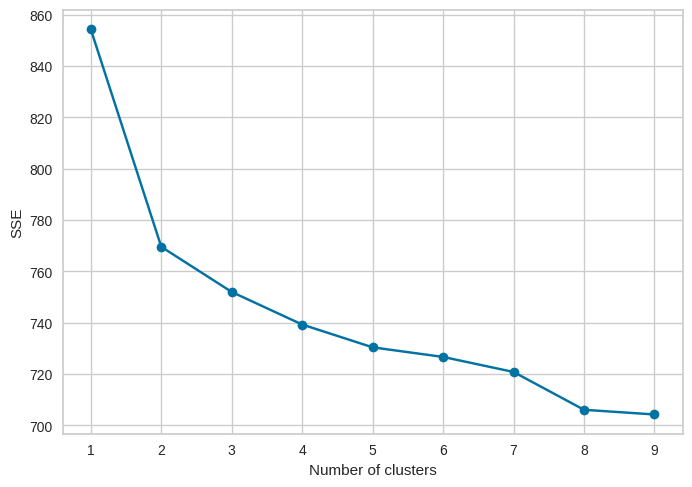

In [ ]:
SSE_list = []
for i in range(1, 10):
    kmeans_sse = KMeans(
        n_clusters=i, init='random', max_iter=300,
        tol=1e-04, random_state=0
    )
    kmeans_sse.fit(tfidf_matrix)
    SSE_list.append(kmeans_sse.inertia_)
plt.plot(range(1, 10), SSE_list, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

# Silhouette scores for the clusters from 2 to 10

In [ ]:
silhouette = []
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, preds)
    silhouette.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.08363995598207957)
For n_clusters = 3, silhouette score is 0.042094954754457084)
For n_clusters = 4, silhouette score is 0.04215309861198682)
For n_clusters = 5, silhouette score is 0.05482613919348227)
For n_clusters = 6, silhouette score is 0.06748881500299109)
For n_clusters = 7, silhouette score is 0.06210690306876979)
For n_clusters = 8, silhouette score is 0.0705586621453266)
For n_clusters = 9, silhouette score is 0.07509264541395337)


## Here, the optimal cluster found is 5 from the elbow method as well as silhouette analysis

# Now, we perform K-means clustering for the technology data for forming the clusters

In [ ]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [ ]:
km.cluster_centers_.argsort()[:, ::-1]

array([[296, 639, 486, ..., 648, 647, 499],
       [296, 639, 634, ..., 645, 644,   0],
       [ 28, 935, 587, ..., 336, 335,   0],
       [296, 714, 352, ..., 633, 632,   0],
       [471, 643, 587, ..., 823, 822,   0]])

# These are the top terms per cluster

In [ ]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
store_economy_clusters = []
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :5]:
        print (' %s' % terms[ind])
    temp = []
    for ind in sorted(order_centroids[i, :]):
            if order_centroids[i,ind]>= 700:
              temp.append(terms[ind])
    store_economy_clusters.append(temp)

Top terms per cluster:
Cluster 0:
 essay
 pay
 javascript
 biology
 physics
Cluster 1:
 essay
 pay
 paper
 class
 biology
Cluster 2:
 amp
 understand
 money
 work
 biden
Cluster 3:
 essay
 psychology
 finance
 homework
 class
Cluster 4:
 inflation
 people
 money
 years
 americans


# We proceed with Dimensionality reduction using Multidimensionality scaling method

## For this we define a error term as the cosine similarity distance matrix using which we will subtract the actual matrix and pass it to the MDS method

In [ ]:
dist = 1 - cosine_similarity(tfidf_matrix)


In [ ]:
userid_economy = data.user
location_economy = data.location

# Implementing the MDS method

In [ ]:
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'economy_Cluster 0', 
                 1: 'economy_Cluster 1', 
                 2: 'economy_Cluster 2', 
                 3: 'economy_Cluster 3', 
                 4: 'economy_Cluster 4'}

# Visualizing the clusters with usernames

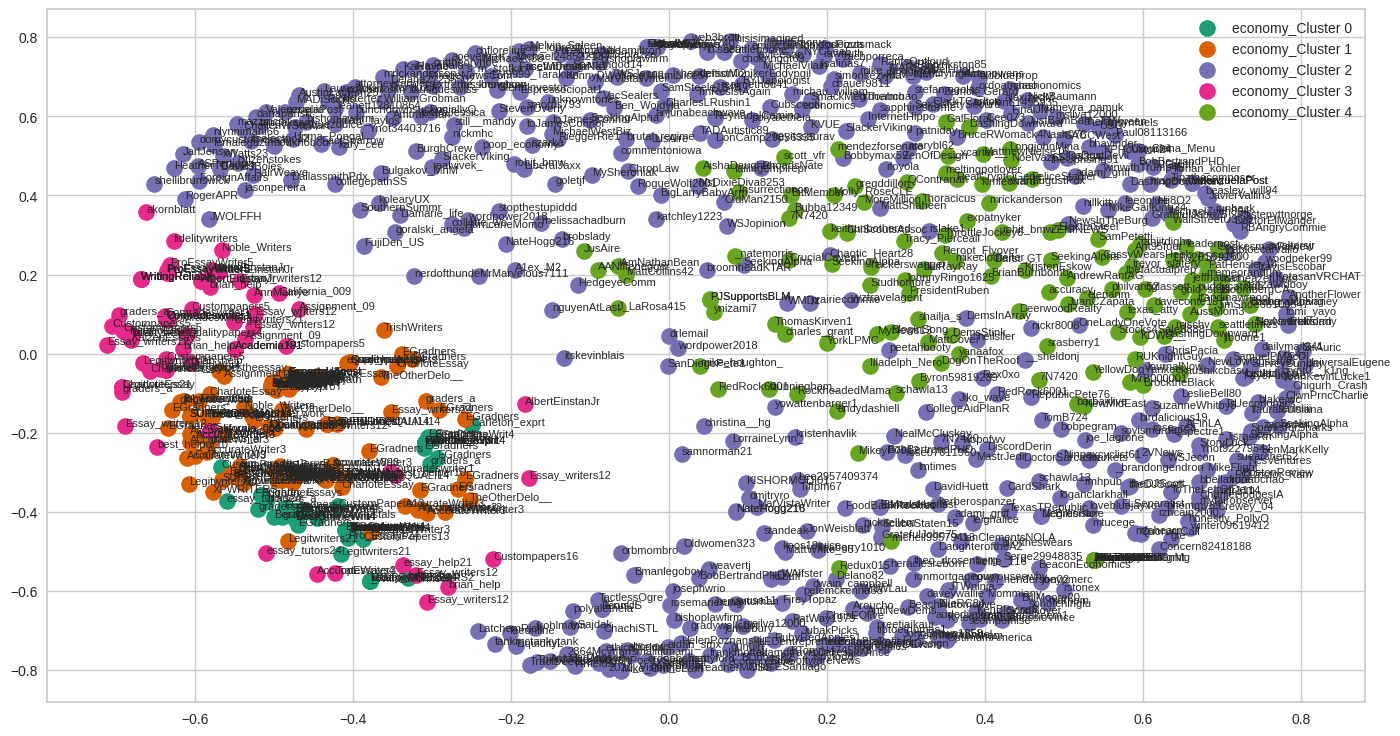

In [ ]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=userid_economy.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show()

# Visualizing the clusters without the usernames

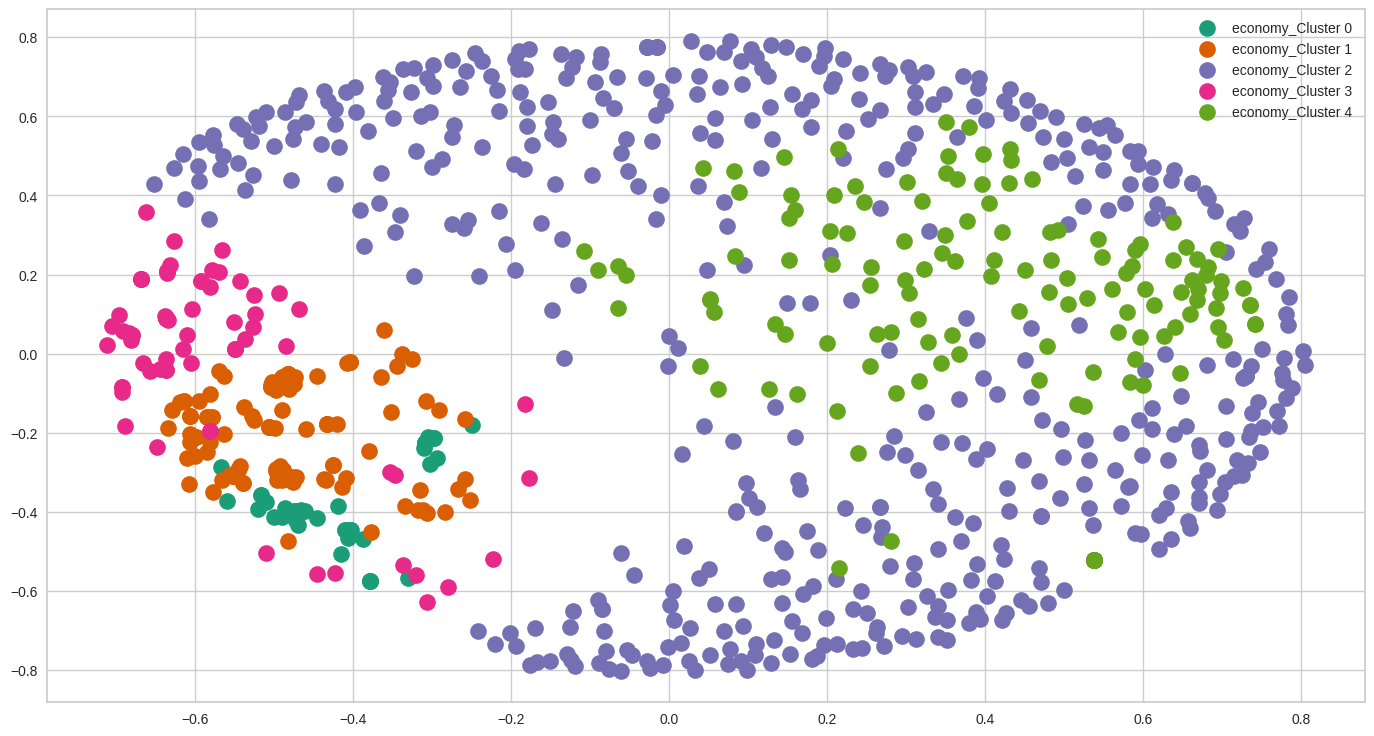

In [ ]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=userid_economy.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)    
plt.show()

In [ ]:
data['cluster'] = clusters

In [ ]:
data.head()

user       location  \
0           KDWS__    Atlanta, GA   
1        HairWeave   Philadelphia   
2   OneLadyOneVote            USA   
3  punchdownsuckup  United States   
4      powanikutin      Bronx, NY   

                                                                                                 tweet  \
0                          hard disagree worry tweet joe biden lack competency example inflation stock   
1               fair finance whore critical totally condone finance corporate government amp mob whore   
2  wsj biden stagflation usa america biden trump trump freedom patriots democrats republicans infla...   
3  canada underfunding defense defend canada defend canada country neuter europe establish global r...   
4                                       osha open investigation amazon warehouse collapse tornado kill   

                                                                                       tokenized_sents  \
0              [hard, disagree, worry, tweet, joe, biden, lack, competency, example, inflation, stock]   
1  [fair, finance, whore, critical, totally, condone, finance, corporate, government, amp, mob, whore]   
2  [wsj, biden, stagflation, usa, america, biden, trump, trump, freedom, patriots, democrats, repub...   
3  [canada, underfunding, defense, defend, canada, defend, canada, country, neuter, europe, establi...   
4                              [osha, open, investigation, amazon, warehouse, collapse, tornado, kill]   

   cluster  
0        4  
1        2  
2        2  
3        2  
4        2

In [ ]:
data_economy = data.copy()

In [ ]:
data_economy.head()

user       location  \
0           KDWS__    Atlanta, GA   
1        HairWeave   Philadelphia   
2   OneLadyOneVote            USA   
3  punchdownsuckup  United States   
4      powanikutin      Bronx, NY   

                                                                                                 tweet  \
0                          hard disagree worry tweet joe biden lack competency example inflation stock   
1               fair finance whore critical totally condone finance corporate government amp mob whore   
2  wsj biden stagflation usa america biden trump trump freedom patriots democrats republicans infla...   
3  canada underfunding defense defend canada defend canada country neuter europe establish global r...   
4                                       osha open investigation amazon warehouse collapse tornado kill   

                                                                                       tokenized_sents  \
0              [hard, disagree, worry, tweet, joe, biden, lack, competency, example, inflation, stock]   
1  [fair, finance, whore, critical, totally, condone, finance, corporate, government, amp, mob, whore]   
2  [wsj, biden, stagflation, usa, america, biden, trump, trump, freedom, patriots, democrats, repub...   
3  [canada, underfunding, defense, defend, canada, defend, canada, country, neuter, europe, establi...   
4                              [osha, open, investigation, amazon, warehouse, collapse, tornado, kill]   

   cluster  
0        4  
1        2  
2        2  
3        2  
4        2

In [ ]:
tfidf_todense = tfidf_matrix.todense()

In [ ]:
tfidf_todense

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

# PHASE 2 : SENTIMENT ANALYSIS

# Performing NRC Lexicon for Each Clusters in Technology Community

#### For Cluster 1

In [ ]:
tfidf_dict_economyc1 = {}
for token in store_economy_clusters[0]: 
    if token not in tfidf_dict_economyc1:
        if token in feature_names:
            tfidf_dict_economyc1[token] = np.max(tfidf_todense[:,np.where(feature_names == token)])

In [ ]:
processed_score = {}
for i in range(len(store_economy_clusters[0])):
    processed_score[i] = 0
    try:
        processed_score[i] += tfidf_dict_economyc1[store_economy_clusters[0][i].lower()]
    except:
        continue

In [ ]:
top_tweets= [(k, l) for k,l in sorted(processed_score.items(), key= lambda x: x[1], reverse=True)]


## Main code snippet for NRC Lexicon


In [ ]:
data_emotion = open("NRC-Lexicon.txt")
next(data_emotion)
emotion_lexicon = {}
for line in data_emotion:
    word, emotion, score = line.strip().split("\t")
    if word in emotion_lexicon:
        emotion_lexicon[word].update({emotion: float(score)})
    else:
        emotion_lexicon.update({word: {emotion:float(score)}})

## Here, we try to process all the words in the tweets and give the score related to NRC Lexicon to each tweet and try to gain the emotion related to each tweet

In [ ]:
emotions = list(emotion_lexicon['kill'].keys())

# computing emotional scores for tweets
# top tweets index and score = top_tweets
# Non Normalized here
res_list = [0]*len(emotions)
top_tweets_el = []
#top_tweets_ad = []
#top_tweets_dv = []()
for tweet in top_tweets:
    emotion_score = [0]*len(emotions)
    index = tweet[0]
    clean_tweet = store_economy_clusters[0][index]
    #print("tweet: ",clean_tweet)
    for each_word in clean_tweet.split():
        if each_word in emotion_lexicon:
            temp = []
            for each_emotion in emotion_lexicon[each_word]:
                temp.append(emotion_lexicon[each_word][each_emotion])
            emotion_score = [temp[i] + emotion_score[i] for i in range(len(emotions))]
    top_tweets_el.append(emotion_score)
    res_list = [emotion_score[i] + res_list[i] for i in range(len(emotions))]

### Result list comprises of the whole emotion scores related to 10 different emotions in NRC Lexicon

In [ ]:
res_list

[13.0, 17.0, 8.0, 14.0, 11.0, 28.0, 43.0, 16.0, 6.0, 26.0]

## From here, we perform the same set of steps for all the 5 clusters 

#### For Cluster 2

In [ ]:
tfidf_dict_economyc2 = {}
for token in store_economy_clusters[1]: 
    if token not in tfidf_dict_economyc2:
        if token in feature_names:
            tfidf_dict_economyc2[token] = np.max(tfidf_todense[:,np.where(feature_names ==token)])

In [ ]:
processed_score2 = {}
for i in range(len(store_economy_clusters[1])):
    processed_score2[i] = 0
    try:
        processed_score2[i] += tfidf_dict_economyc2[store_economy_clusters[1][i].lower()]
    except:
        continue

In [ ]:
top_tweets2= [(k, l) for k,l in sorted(processed_score2.items(), key= lambda x: x[1], reverse=True)]


In [ ]:
data_emotion = open("NRC-Lexicon.txt")
next(data_emotion)
emotion_lexicon = {}
for line in data_emotion:
    word, emotion, score = line.strip().split("\t")
    if word in emotion_lexicon:
        emotion_lexicon[word].update({emotion: float(score)})
    else:
        emotion_lexicon.update({word: {emotion:float(score)}})

In [ ]:
emotions = list(emotion_lexicon['kill'].keys())

# computing emotional scores for tweets
# top tweets index and score = top_tweets
# Non Normalized here
res_list2 = [0]*len(emotions)
top_tweets_el = []
#top_tweets_ad = []
#top_tweets_dv = []()
for tweet in top_tweets2:
    emotion_score = [0]*len(emotions)
    index = tweet[0]
    clean_tweet2 = store_economy_clusters[1][index]
    #print("tweet: ",clean_tweet)
    for each_word in clean_tweet2.split():
        if each_word in emotion_lexicon:
            temp = []
            for each_emotion in emotion_lexicon[each_word]:
                temp.append(emotion_lexicon[each_word][each_emotion])
            emotion_score = [temp[i] + emotion_score[i] for i in range(len(emotions))]
    top_tweets_el.append(emotion_score)
    res_list2 = [emotion_score[i] + res_list2[i] for i in range(len(emotions))]

In [ ]:
res_list2

[9.0, 16.0, 6.0, 12.0, 10.0, 22.0, 42.0, 11.0, 6.0, 26.0]

#### For Cluster 3

In [ ]:
tfidf_dict_economyc3 = {}
for token in store_economy_clusters[2]: 
    if token not in tfidf_dict_economyc3:
        if token in feature_names:
            tfidf_dict_economyc3[token] = np.max(tfidf_todense[:,np.where(feature_names ==token)])

In [ ]:
processed_score3 = {}
for i in range(len(store_economy_clusters[2])):
    processed_score3[i] = 0
    try:
        processed_score3[i] += tfidf_dict_economyc3[store_economy_clusters[2][i].lower()]
    except:
        continue

In [ ]:
top_tweets3= [(k, l) for k,l in sorted(processed_score3.items(), key= lambda x: x[1], reverse=True)]


In [ ]:
data_emotion = open("NRC-Lexicon.txt")
next(data_emotion)
emotion_lexicon = {}
for line in data_emotion:
    word, emotion, score = line.strip().split("\t")
    if word in emotion_lexicon:
        emotion_lexicon[word].update({emotion: float(score)})
    else:
        emotion_lexicon.update({word: {emotion:float(score)}})

In [ ]:
emotions = list(emotion_lexicon['kill'].keys())

# computing emotional scores for tweets
# top tweets index and score = top_tweets
# Non Normalized here
res_list3 = [0]*len(emotions)
top_tweets_el = []
#top_tweets_ad = []
#top_tweets_dv = []()
for tweet in top_tweets3:
    emotion_score = [0]*len(emotions)
    index = tweet[0]
    clean_tweet3 = store_economy_clusters[2][index]
    #print("tweet: ",clean_tweet)
    for each_word in clean_tweet3.split():
        if each_word in emotion_lexicon:
            temp = []
            for each_emotion in emotion_lexicon[each_word]:
                temp.append(emotion_lexicon[each_word][each_emotion])
            emotion_score = [temp[i] + emotion_score[i] for i in range(len(emotions))]
    top_tweets_el.append(emotion_score)
    res_list3 = [emotion_score[i] + res_list3[i] for i in range(len(emotions))]

In [ ]:
res_list3

[14.0, 16.0, 4.0, 16.0, 12.0, 28.0, 46.0, 12.0, 10.0, 22.0]

#### For Cluster 4

In [ ]:
tfidf_dict_economyc4 = {}
for token in store_economy_clusters[3]: 
    if token not in tfidf_dict_economyc4:
        if token in feature_names:
            tfidf_dict_economyc4[token] = np.max(tfidf_todense[:,np.where(feature_names ==token)])

In [ ]:
processed_score4 = {}
for i in range(len(store_economy_clusters[3])):
    processed_score4[i] = 0
    try:
        processed_score4[i] += tfidf_dict_economyc4[store_economy_clusters[3][i].lower()]
    except:
        continue

In [ ]:
top_tweets4= [(k, l) for k,l in sorted(processed_score4.items(), key= lambda x: x[1], reverse=True)]


In [ ]:
data_emotion = open("NRC-Lexicon.txt")
next(data_emotion)
emotion_lexicon = {}
for line in data_emotion:
    word, emotion, score = line.strip().split("\t")
    if word in emotion_lexicon:
        emotion_lexicon[word].update({emotion: float(score)})
    else:
        emotion_lexicon.update({word: {emotion:float(score)}})

In [ ]:
emotions = list(emotion_lexicon['kill'].keys())

# computing emotional scores for tweets
# top tweets index and score = top_tweets
# Non Normalized here
res_list4 = [0]*len(emotions)
top_tweets_el = []
#top_tweets_ad = []
#top_tweets_dv = []()
for tweet in top_tweets4:
    emotion_score = [0]*len(emotions)
    index = tweet[0]
    clean_tweet4 = store_economy_clusters[3][index]
    #print("tweet: ",clean_tweet)
    for each_word in clean_tweet4.split():
        if each_word in emotion_lexicon:
            temp = []
            for each_emotion in emotion_lexicon[each_word]:
                temp.append(emotion_lexicon[each_word][each_emotion])
            emotion_score = [temp[i] + emotion_score[i] for i in range(len(emotions))]
    top_tweets_el.append(emotion_score)
    res_list4 = [emotion_score[i] + res_list4[i] for i in range(len(emotions))]

In [ ]:
res_list4

[13.0, 14.0, 8.0, 15.0, 11.0, 28.0, 46.0, 14.0, 5.0, 28.0]

#### For Cluster 5

In [ ]:
tfidf_dict_economyc5 = {}
for token in store_economy_clusters[4]: 
    if token not in tfidf_dict_economyc5:
        if token in feature_names:
            tfidf_dict_economyc5[token] = np.max(tfidf_todense[:,np.where(feature_names ==token)])

In [ ]:
processed_score5 = {}
for i in range(len(store_economy_clusters[4])):
    processed_score5[i] = 0
    try:
        processed_score5[i] += tfidf_dict_economyc5[store_economy_clusters[4][i].lower()]
    except:
        continue

In [ ]:
top_tweets5= [(k, l) for k,l in sorted(processed_score5.items(), key= lambda x: x[1], reverse=True)]


In [ ]:
data_emotion = open("NRC-Lexicon.txt")
next(data_emotion)
emotion_lexicon = {}
for line in data_emotion:
    word, emotion, score = line.strip().split("\t")
    if word in emotion_lexicon:
        emotion_lexicon[word].update({emotion: float(score)})
    else:
        emotion_lexicon.update({word: {emotion:float(score)}})

In [ ]:
emotions = list(emotion_lexicon['kill'].keys())

# computing emotional scores for tweets
# top tweets index and score = top_tweets
# Non Normalized here
res_list5 = [0]*len(emotions)
top_tweets_el = []
#top_tweets_ad = []
#top_tweets_dv = []()
for tweet in top_tweets5:
    emotion_score = [0]*len(emotions)
    index = tweet[0]
    clean_tweet5 = store_economy_clusters[4][index]
    #print("tweet: ",clean_tweet)
    for each_word in clean_tweet5.split():
        if each_word in emotion_lexicon:
            temp = []
            for each_emotion in emotion_lexicon[each_word]:
                temp.append(emotion_lexicon[each_word][each_emotion])
            emotion_score = [temp[i] + emotion_score[i] for i in range(len(emotions))]
    top_tweets_el.append(emotion_score)
    res_list5 = [emotion_score[i] + res_list5[i] for i in range(len(emotions))]

In [ ]:
res_list5

[20.0, 17.0, 13.0, 21.0, 19.0, 36.0, 46.0, 15.0, 10.0, 26.0]

# Using the resulting emotions above we plot the same for decoding and analyzing the emotions for all the clusters

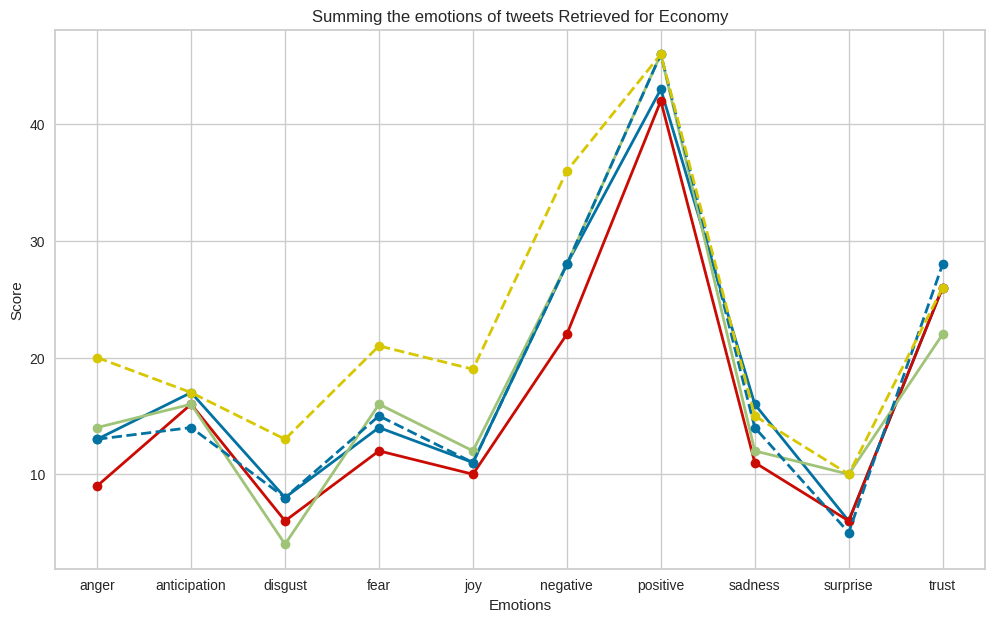

In [ ]:
from matplotlib import cm
# Bar plot of overall emotions of the tweets:
# for each tweet we have added the emotion score ---- NOT NORMALIZED
# then summed all emotions over all tweets:
viridis = cm.get_cmap('viridis',10)
#print(viridis)
plt.figure(figsize=(12,7))

plt.title("Summing the emotions of tweets Retrieved for Economy")
plt.xlabel("Emotions")
plt.ylabel("Score")
plt.plot(emotions,res_list,'bo-',label="Cluster1",linewidth=2)
plt.plot(emotions,res_list2,'ro-',label="Cluster2",linewidth=2)
plt.plot(emotions,res_list3,'go-',label="Cluster3",linewidth=2)
plt.plot(emotions,res_list4,'bo--',label="Cluster4",linewidth=2)
plt.plot(emotions,res_list5,'yo--',label="Cluster5",linewidth=2)

plt.show()

# Performing NRC VAD Lexicon for Each Clusters in Technology Community

### Loading the file into the dictionary

In [ ]:
# Sentimental analysis using Valance Arousal and Dominace Data

# loading the file into a dictionary
data_lexicon = open("NRC-VAD-Lexicon.txt")
next(data_lexicon)
vad = {}
for line in data_lexicon:
    word, var, aro, dom = line.strip().split("\t")
    vad[word] = [float(var),float(aro),float(dom)]


#### For Cluster 1

### Visualizing the VAD GRAPHS for each tweets by correlating the scores from the lexicon dictionary to the keywords in the tweets

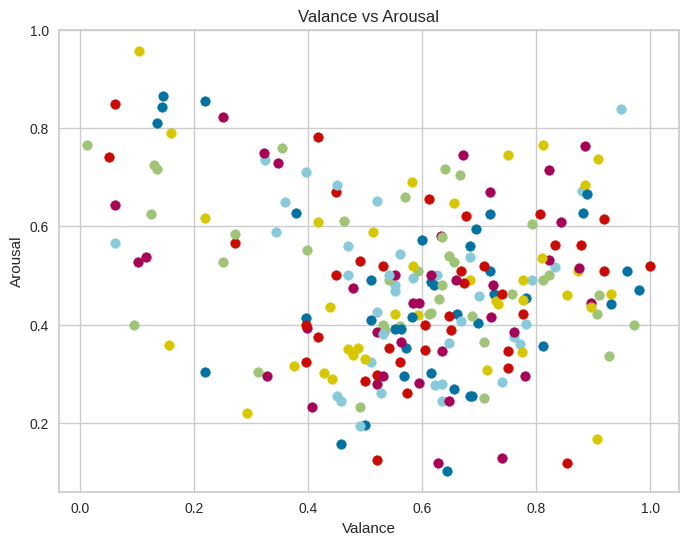

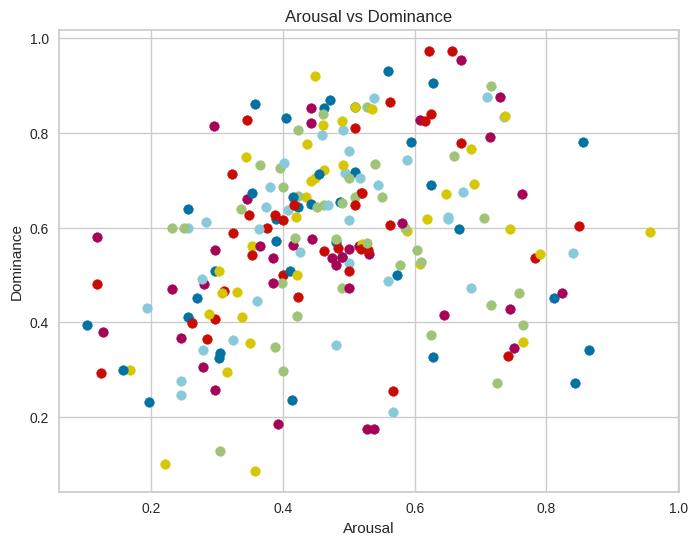

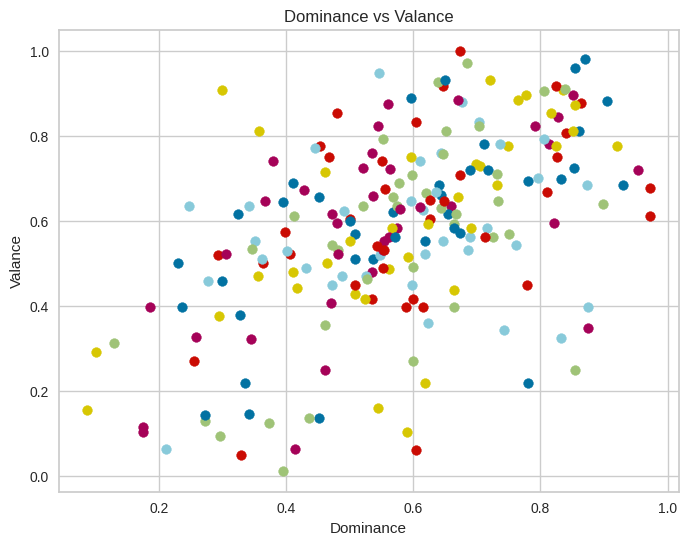

In [ ]:
# calculating the valance arousal and dominance scores
# top tweets index and score = top_tweets
top_tweets_va1 = []
top_tweets_ad1 = []
top_tweets_dv1 = []
for tweet in top_tweets:
    index = tweet[0]
    clean_tweet1 = store_economy_clusters[0][index]
    #print("tweet: ",clean_tweet)
    count = 0
    val_score1 = 0
    arousal_score1 = 0
    dominance_score1 = 0
    for each_word in clean_tweet1.split():
        if each_word in vad:
            val_score1 += vad[each_word][0]
            arousal_score1 += vad[each_word][1]
            dominance_score1 += vad[each_word][2]
            count += 1
    # averaging the score over the words in tweets to get appropriate scores for each tweet
    if count!= 0:
        top_tweets_va1.append([val_score1/count, arousal_score1/count])
        top_tweets_ad1.append([arousal_score1/count, dominance_score1/count])
        top_tweets_dv1.append([dominance_score1/count, val_score1/count])

#-----------------------------------------------------------------------------------------------------------
# Valance vs Arousal
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va1)):
  plt.scatter(top_tweets_va1[i][0], top_tweets_va1[i][1]) # plt.scatter(x,y,color)  
plt.title('Valance vs Arousal')
plt.xlabel('Valance')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()

#-----------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va1)):
  plt.scatter(top_tweets_ad1[i][0], top_tweets_ad1[i][1]) # plt.scatter(x,y,color)  
plt.title('Arousal vs Dominance')
plt.xlabel('Arousal')
plt.ylabel('Dominance')
plt.grid(True)
plt.show()

#---------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va1)):
  plt.scatter(top_tweets_dv1[i][0], top_tweets_dv1[i][1]) # plt.scatter(x,y,color)  
plt.title('Dominance vs Valance')
plt.xlabel('Dominance')
plt.ylabel('Valance')
plt.grid(True)
plt.show()

### We perform the same set of steps henceforth for all the 5 clusters

#### For Cluster 2

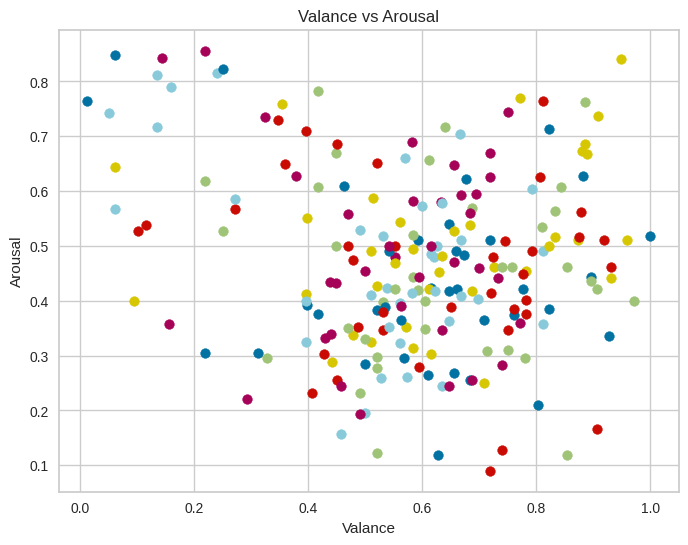

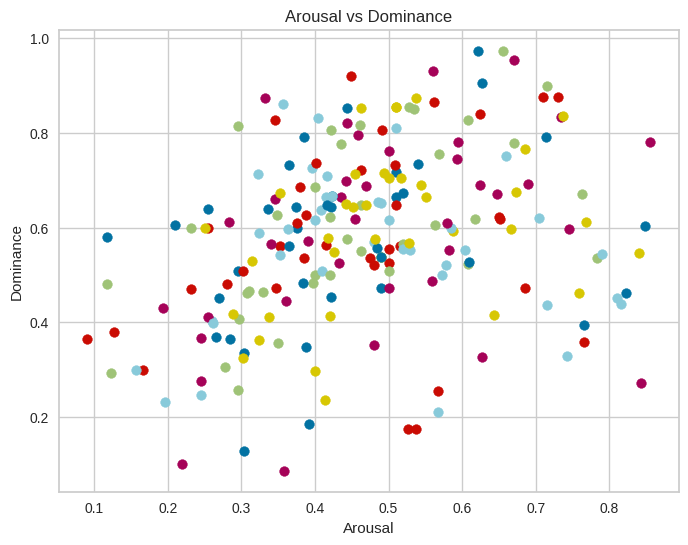

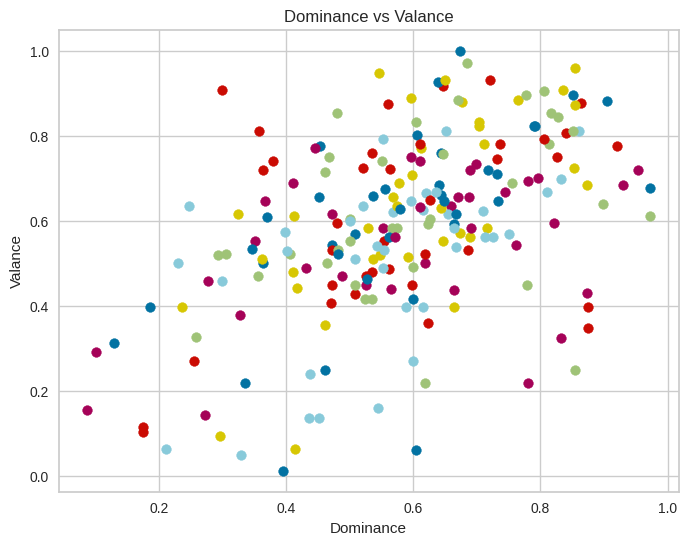

In [ ]:
# calculating the valance arousal and dominance scores
# top tweets index and score = top_tweets
top_tweets_va2 = []
top_tweets_ad2 = []
top_tweets_dv2 = []
for tweet in top_tweets2:
    index = tweet[0]
    clean_tweet2 = store_economy_clusters[1][index]
    #print("tweet: ",clean_tweet)
    count = 0
    val_score2 = 0
    arousal_score2 = 0
    dominance_score2 = 0
    for each_word in clean_tweet2.split():
        if each_word in vad:
            val_score2 += vad[each_word][0]
            arousal_score2 += vad[each_word][1]
            dominance_score2 += vad[each_word][2]
            count += 1
    # averaging the score over the words in tweets to get appropriate scores for each tweet
    if count!= 0:
        top_tweets_va2.append([val_score2/count, arousal_score2/count])
        top_tweets_ad2.append([arousal_score2/count, dominance_score2/count])
        top_tweets_dv2.append([dominance_score2/count, val_score2/count])

#-----------------------------------------------------------------------------------------------------------
# Valance vs Arousal
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va2)):
  plt.scatter(top_tweets_va2[i][0], top_tweets_va2[i][1]) # plt.scatter(x,y,color)  
plt.title('Valance vs Arousal')
plt.xlabel('Valance')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()

#-----------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va2)):
  plt.scatter(top_tweets_ad2[i][0], top_tweets_ad2[i][1]) # plt.scatter(x,y,color)  
plt.title('Arousal vs Dominance')
plt.xlabel('Arousal')
plt.ylabel('Dominance')
plt.grid(True)
plt.show()

#---------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va2)):
  plt.scatter(top_tweets_dv2[i][0], top_tweets_dv2[i][1]) # plt.scatter(x,y,color)  
plt.title('Dominance vs Valance')
plt.xlabel('Dominance')
plt.ylabel('Valance')
plt.grid(True)
plt.show()

#### For Cluster 3

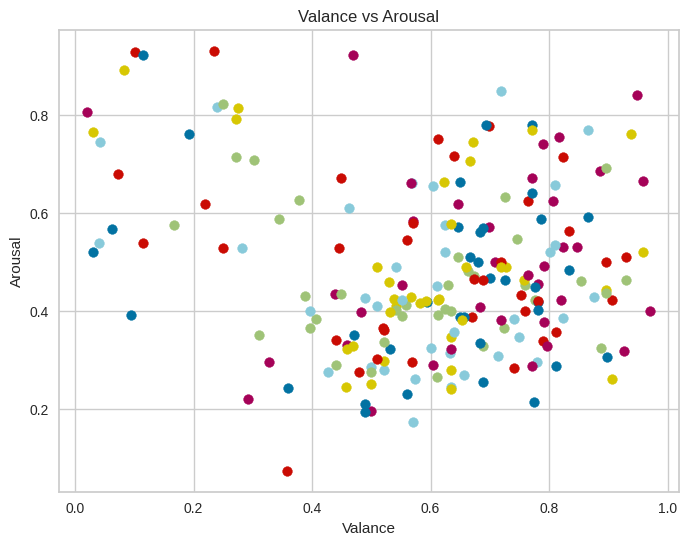

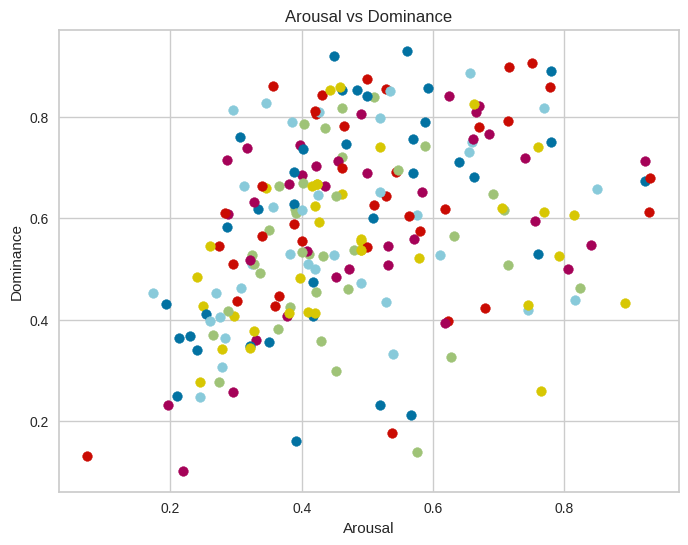

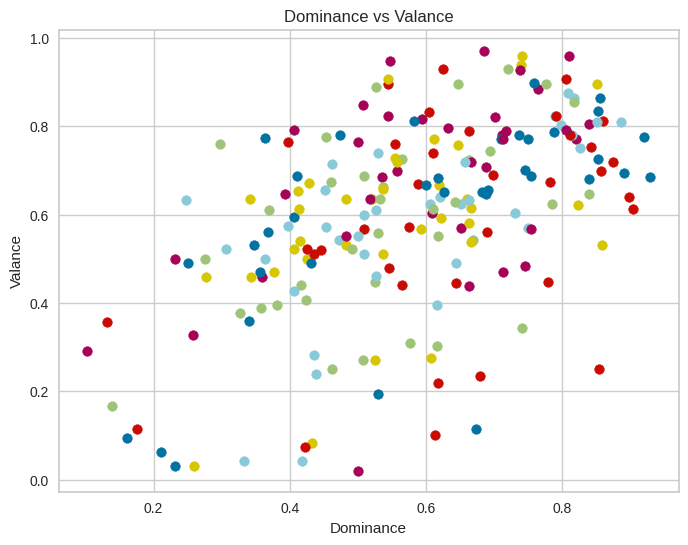

In [ ]:
# calculating the valance arousal and dominance scores
# top tweets index and score = top_tweets
top_tweets_va3 = []
top_tweets_ad3 = []
top_tweets_dv3 = []
for tweet in top_tweets3:
    index = tweet[0]
    clean_tweet3 = store_economy_clusters[2][index]
    #print("tweet: ",clean_tweet)
    count = 0
    val_score3 = 0
    arousal_score3 = 0
    dominance_score3 = 0
    for each_word in clean_tweet3.split():
        if each_word in vad:
            val_score3 += vad[each_word][0]
            arousal_score3 += vad[each_word][1]
            dominance_score3 += vad[each_word][2]
            count += 1
    # averaging the score over the words in tweets to get appropriate scores for each tweet
    if count!= 0:
        top_tweets_va3.append([val_score3/count, arousal_score3/count])
        top_tweets_ad3.append([arousal_score3/count, dominance_score3/count])
        top_tweets_dv3.append([dominance_score3/count, val_score3/count])

#-----------------------------------------------------------------------------------------------------------
# Valance vs Arousal
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va3)):
  plt.scatter(top_tweets_va3[i][0], top_tweets_va3[i][1]) # plt.scatter(x,y,color)  
plt.title('Valance vs Arousal')
plt.xlabel('Valance')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()

#-----------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va3)):
  plt.scatter(top_tweets_ad3[i][0], top_tweets_ad3[i][1]) # plt.scatter(x,y,color)  
plt.title('Arousal vs Dominance')
plt.xlabel('Arousal')
plt.ylabel('Dominance')
plt.grid(True)
plt.show()

#---------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va3)):
  plt.scatter(top_tweets_dv3[i][0], top_tweets_dv3[i][1]) # plt.scatter(x,y,color)  
plt.title('Dominance vs Valance')
plt.xlabel('Dominance')
plt.ylabel('Valance')
plt.grid(True)
plt.show()

#### For Cluster 4

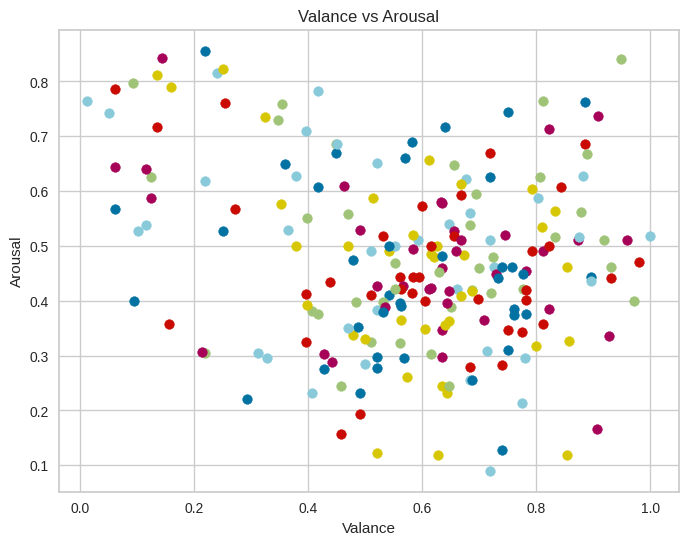

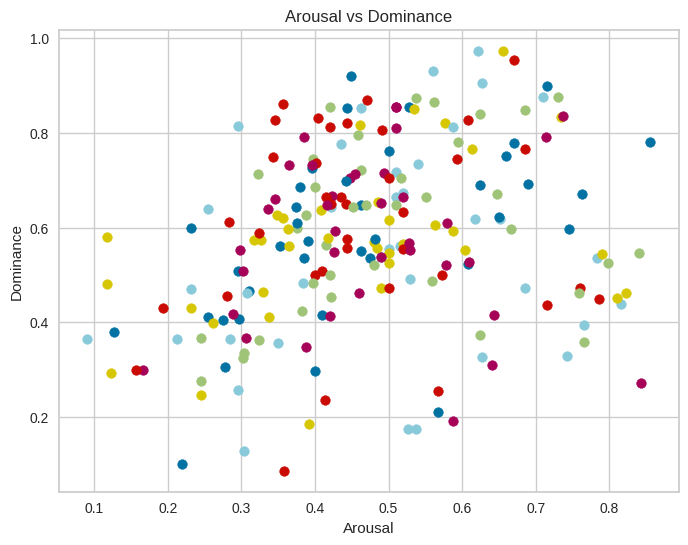

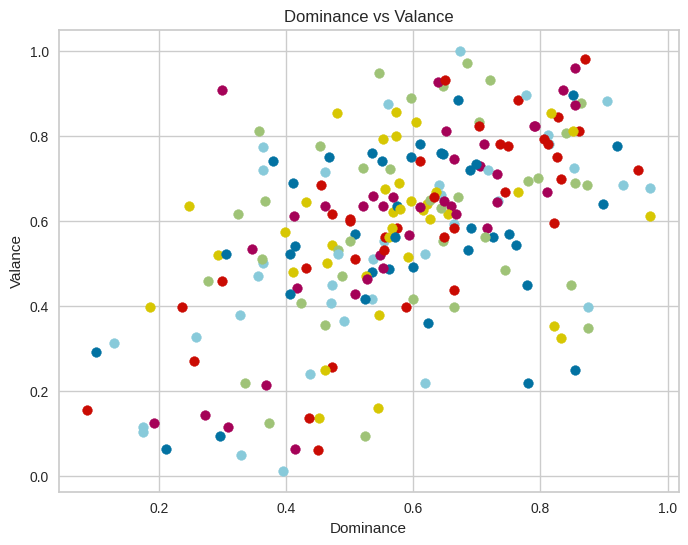

In [ ]:
# calculating the valance arousal and dominance scores
# top tweets index and score = top_tweets
top_tweets_va4 = []
top_tweets_ad4 = []
top_tweets_dv4 = []
for tweet in top_tweets4:
    index = tweet[0]
    clean_tweet4 = store_economy_clusters[3][index]
    #print("tweet: ",clean_tweet)
    count = 0
    val_score4 = 0
    arousal_score4 = 0
    dominance_score4 = 0
    for each_word in clean_tweet4.split():
        if each_word in vad:
            val_score4 += vad[each_word][0]
            arousal_score4 += vad[each_word][1]
            dominance_score4 += vad[each_word][2]
            count += 1
    # averaging the score over the words in tweets to get appropriate scores for each tweet
    if count!= 0:
        top_tweets_va4.append([val_score4/count, arousal_score4/count])
        top_tweets_ad4.append([arousal_score4/count, dominance_score4/count])
        top_tweets_dv4.append([dominance_score4/count, val_score4/count])

#-----------------------------------------------------------------------------------------------------------
# Valance vs Arousal
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va4)):
  plt.scatter(top_tweets_va4[i][0], top_tweets_va4[i][1]) # plt.scatter(x,y,color)  
plt.title('Valance vs Arousal')
plt.xlabel('Valance')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()

#-----------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va4)):
  plt.scatter(top_tweets_ad4[i][0], top_tweets_ad4[i][1]) # plt.scatter(x,y,color)  
plt.title('Arousal vs Dominance')
plt.xlabel('Arousal')
plt.ylabel('Dominance')
plt.grid(True)
plt.show()

#---------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va4)):
  plt.scatter(top_tweets_dv4[i][0], top_tweets_dv4[i][1]) # plt.scatter(x,y,color)  
plt.title('Dominance vs Valance')
plt.xlabel('Dominance')
plt.ylabel('Valance')
plt.grid(True)
plt.show()

#### For Cluster 5

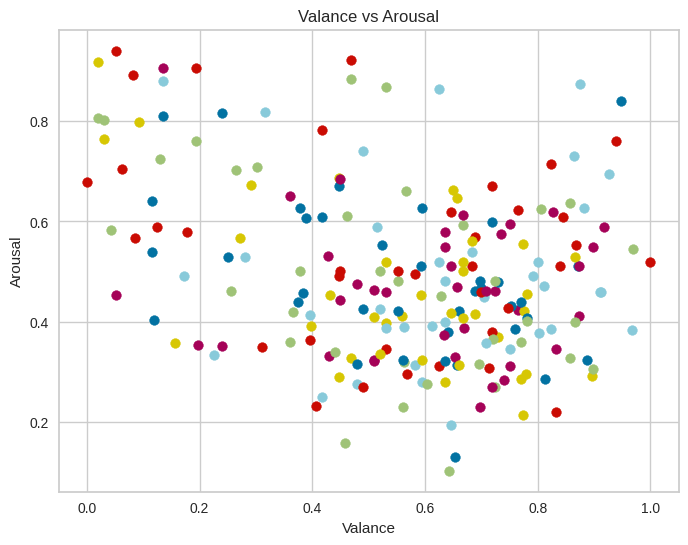

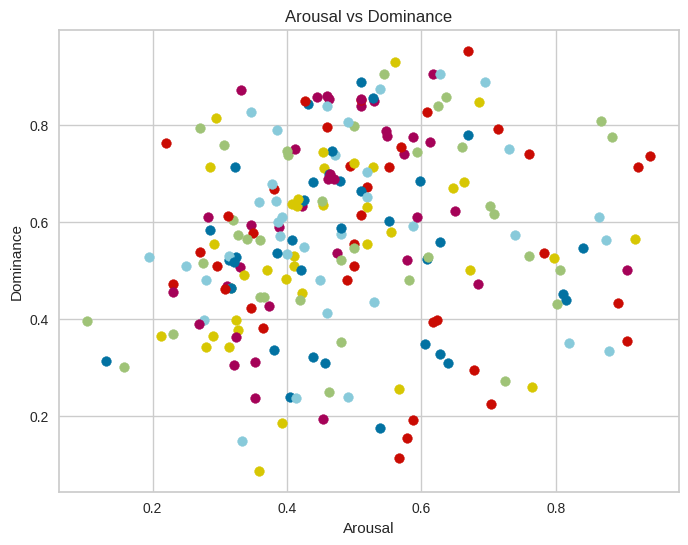

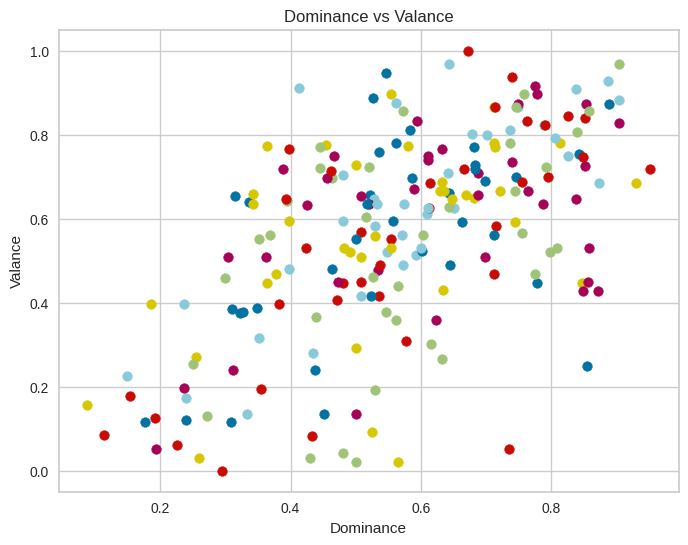

In [ ]:
# calculating the valance arousal and dominance scores
# top tweets index and score = top_tweets
top_tweets_va5 = []
top_tweets_ad5 = []
top_tweets_dv5 = []
for tweet in top_tweets5:
    index = tweet[0]
    clean_tweet5 = store_economy_clusters[4][index]
    #print("tweet: ",clean_tweet)
    count = 0
    val_score5 = 0
    arousal_score5 = 0
    dominance_score5 = 0
    for each_word in clean_tweet5.split():
        if each_word in vad:
            val_score5 += vad[each_word][0]
            arousal_score5 += vad[each_word][1]
            dominance_score5 += vad[each_word][2]
            count += 1
    # averaging the score over the words in tweets to get appropriate scores for each tweet
    if count!= 0:
        top_tweets_va5.append([val_score5/count, arousal_score5/count])
        top_tweets_ad5.append([arousal_score5/count, dominance_score5/count])
        top_tweets_dv5.append([dominance_score5/count, val_score5/count])

#-----------------------------------------------------------------------------------------------------------
# Valance vs Arousal
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va5)):
  plt.scatter(top_tweets_va5[i][0], top_tweets_va5[i][1]) # plt.scatter(x,y,color)  
plt.title('Valance vs Arousal')
plt.xlabel('Valance')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()

#-----------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va5)):
  plt.scatter(top_tweets_ad5[i][0], top_tweets_ad5[i][1]) # plt.scatter(x,y,color)  
plt.title('Arousal vs Dominance')
plt.xlabel('Arousal')
plt.ylabel('Dominance')
plt.grid(True)
plt.show()

#---------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va5)):
  plt.scatter(top_tweets_dv5[i][0], top_tweets_dv5[i][1]) # plt.scatter(x,y,color)  
plt.title('Dominance vs Valance')
plt.xlabel('Dominance')
plt.ylabel('Valance')
plt.grid(True)
plt.show()

# VADER IMPLEMENTATION

In [ ]:
analyzer = SentimentIntensityAnalyzer()
data['vader_scores'] = data['tokenized_sents'].apply(lambda x: [analyzer.polarity_scores(word) for word in x])

### Taking into consideration the agg VADER scores for all the tweets

In [ ]:
def agg_vader_score(data2):
  return sum([data2[i]['compound'] for i in range(len(data2))])/len(data2)
temp =[]
for i in range(len(data)):
  temp.append(agg_vader_score(data['vader_scores'][i]))

In [ ]:
data['agg_vader_score'] = temp

## Setting the mean cluster polarity for the threshold of the tweets to decide the positive and negative tweets

In [ ]:
mean_cluster_polarity = []
for i in range(0,5):
  #print(i, data['agg_vader_score'][(data.cluster == i)].mean())
  mean_cluster_polarity.append(data['agg_vader_score'][(data.cluster == i)].mean())
print(mean_cluster_polarity)

[0.008496482993447468, 0.0032099384453429056, 0.0022239975147290043, 0.012516467139034357, -0.0008496635401055793]


In [ ]:
sentiments_count_cluster = []
datac1 = data['agg_vader_score'][(data.cluster == 0)]
economy_cluster1_list = datac1.values.tolist()

datac2 = data['agg_vader_score'][(data.cluster == 1)]
economy_cluster2_list = datac2.values.tolist()

datac3 = data['agg_vader_score'][(data.cluster == 2)]
economy_cluster3_list = datac3.values.tolist()

datac4 = data['agg_vader_score'][(data.cluster == 3)]
economy_cluster4_list = datac4.values.tolist()

datac5 = data['agg_vader_score'][(data.cluster == 4)]
economy_cluster5_list = datac5.values.tolist()

## Deduction of total overall positive and negative tweets in each cluster and preparing the data for visualization

#### For Cluster 1

In [ ]:
negative_count = 0
positive_count = 0
for i in range(len(economy_cluster1_list)):
  if economy_cluster1_list[i] < -mean_cluster_polarity[0]:
    negative_count = negative_count + 1
  elif economy_cluster1_list[i] > mean_cluster_polarity[0]:
    positive_count = positive_count + 1
sentiments_count_cluster.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster)

[[30, 3]]


#### For Cluster 2

In [ ]:
for i in range(len(economy_cluster2_list)):
  if economy_cluster2_list[i] < -mean_cluster_polarity[1]:
    negative_count = negative_count + 1
  elif economy_cluster2_list[i] > mean_cluster_polarity[1]:
    positive_count = positive_count + 1
sentiments_count_cluster.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster)

[[30, 3], [76, 80]]


#### For Cluster 3

In [ ]:
for i in range(len(economy_cluster3_list)):
  if economy_cluster3_list[i] < -mean_cluster_polarity[2]:
    negative_count = negative_count + 1
  elif economy_cluster3_list[i] > mean_cluster_polarity[2]:
    positive_count = positive_count + 1
sentiments_count_cluster.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster)

[[30, 3], [76, 80], [211, 191]]


#### For Cluster 4

In [ ]:
for i in range(len(economy_cluster4_list)):
  if economy_cluster4_list[i] < -mean_cluster_polarity[3]:
    negative_count = negative_count + 1
  elif economy_cluster4_list[i] > mean_cluster_polarity[3]:
    positive_count = positive_count + 1
sentiments_count_cluster.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster)

[[30, 3], [76, 80], [211, 191], [32, 1]]


#### For Cluster 5

In [ ]:
for i in range(len(economy_cluster5_list)):
  if economy_cluster5_list[i] < -mean_cluster_polarity[4]:
    negative_count = negative_count + 1
  elif economy_cluster5_list[i] > mean_cluster_polarity[4]:
    positive_count = positive_count + 1
sentiments_count_cluster.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster)

[[30, 3], [76, 80], [211, 191], [32, 1], [68, 72]]


# Graphical representation of VADER for each of the clusters


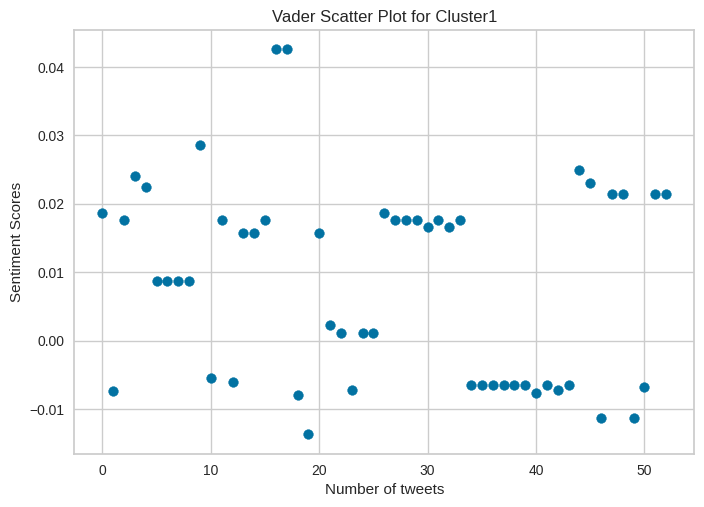

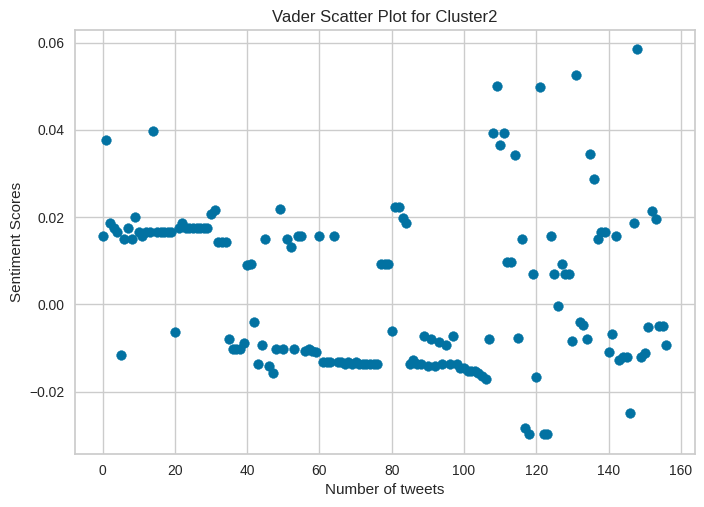

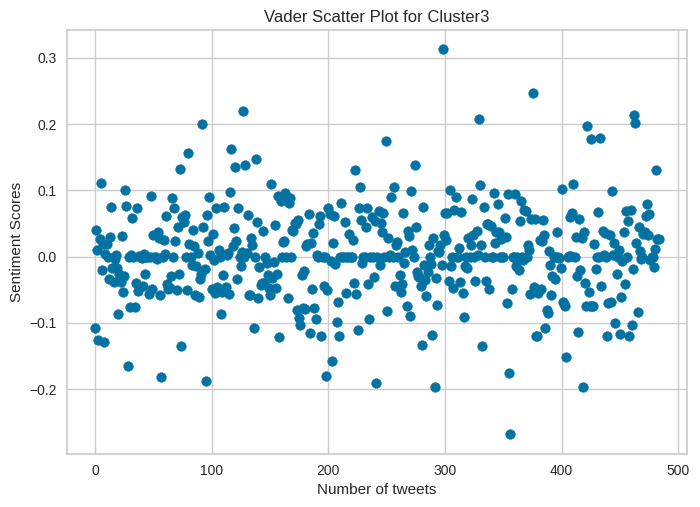

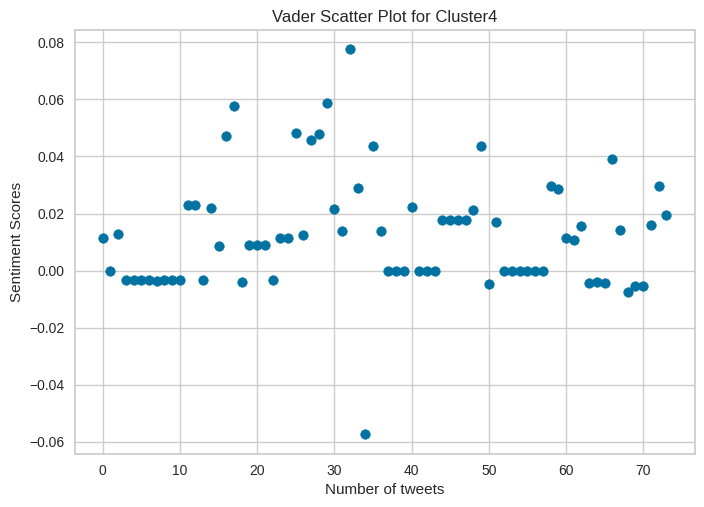

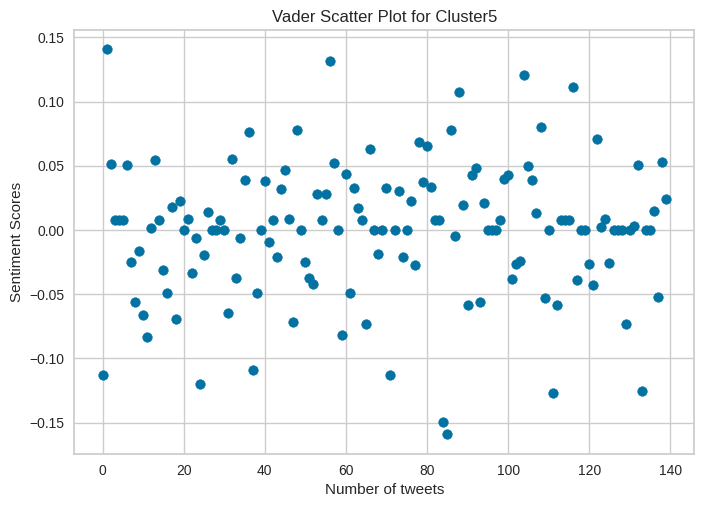

In [ ]:
economy_cluster_list = [economy_cluster1_list,economy_cluster2_list,economy_cluster3_list,economy_cluster4_list, economy_cluster5_list]
i = 1
for subscore in economy_cluster_list:
    x = range(len(subscore))
    plt.scatter(x, subscore)

# Set the x and y axis labels
    plt.xlabel('Number of tweets')
    plt.ylabel('Sentiment Scores')

# Set the title of the plot
    plt.title('Vader Scatter Plot for Cluster' + str(i))
    i+=1

# Show the plot
    plt.show()

# AFINN IMPLEMENTATION

In [ ]:
afinn = Afinn()

data['afinn_scores'] = data['tokenized_sents'].apply(lambda x: [afinn.score(word) for word in x])


In [ ]:
data['afinn_scores']

0                                              [-1.0, -2.0, -3.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0.0, 0.0]
1                                           [2.0, 0.0, -4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.0]
2                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4                                                               [0.0, 0.0, 0.0, 0.0, 0.0, -2.0, 0.0, -3.0]
                                                      ...                                                 
903    [0.0, 0.0, -2.0, 2.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0...
904          [0.0, 0.0, -2.0, 2.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
905                                [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
906                                [2

### Taking into consideration the agg AFINN scores for all the tweets

In [ ]:
def agg_afinn_score(data2):
  return sum([data2[i] for i in range(len(data2))])/len(data2)

temp = []
for i in range(len(data)):
  temp.append(agg_afinn_score(data['afinn_scores'][i]))

In [ ]:
data['agg_afinn_score'] = temp

## Setting the mean cluster polarity for the threshold of the tweets to decide the positive and negative tweets

In [ ]:
mean_cluster_polarity = []
for i in range(0,5):
  #print(i, data['agg_vader_score'][(data.cluster == i)].mean())
  mean_cluster_polarity.append(data['agg_afinn_score'][(data.cluster == i)].mean())
print(mean_cluster_polarity)

[-0.003951115675947225, -0.03998305461489406, -0.029828294587618806, 0.02495104682829634, -0.0223713417303051]


In [ ]:
sentiments_count_cluster_a = []
datac1_a = data['agg_afinn_score'][(data.cluster == 0)]
economy_cluster1_list_a = datac1_a.values.tolist()

datac2_a = data['agg_afinn_score'][(data.cluster == 1)]
economy_cluster2_list_a = datac2_a.values.tolist()

datac3_a = data['agg_afinn_score'][(data.cluster == 2)]
economy_cluster3_list_a = datac3_a.values.tolist()

datac4_a = data['agg_afinn_score'][(data.cluster == 3)]
economy_cluster4_list_a = datac4_a.values.tolist()

datac5_a = data['agg_afinn_score'][(data.cluster == 4)]
economy_cluster5_list_a = datac5_a.values.tolist()

## Deduction of total overall positive and negative tweets in each cluster and preparing the data for visualization

#### For Cluster 1

In [ ]:
negative_count = 0
positive_count = 0
for i in range(len(economy_cluster1_list_a)):
  if economy_cluster1_list_a[i] < -mean_cluster_polarity[0]:
    negative_count = negative_count + 1
  elif economy_cluster1_list_a[i] > mean_cluster_polarity[0]:
    positive_count = positive_count + 1
sentiments_count_cluster_a.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster_a)

[[25, 28]]


#### For Cluster 2

In [ ]:
for i in range(len(economy_cluster2_list_a)):
  if economy_cluster2_list_a[i] < -mean_cluster_polarity[1]:
    negative_count = negative_count + 1
  elif economy_cluster2_list_a[i] > mean_cluster_polarity[1]:
    positive_count = positive_count + 1
sentiments_count_cluster_a.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster_a)

[[25, 28], [58, 99]]


#### For Cluster 3

In [ ]:
for i in range(len(economy_cluster3_list_a)):
  if economy_cluster3_list_a[i] < -mean_cluster_polarity[2]:
    negative_count = negative_count + 1
  elif economy_cluster3_list_a[i] > mean_cluster_polarity[2]:
    positive_count = positive_count + 1
sentiments_count_cluster_a.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster_a)

[[25, 28], [58, 99], [185, 299]]


#### For Cluster 4

In [ ]:
for i in range(len(economy_cluster4_list_a)):
  if economy_cluster4_list_a[i] < -mean_cluster_polarity[3]:
    negative_count = negative_count + 1
  elif economy_cluster4_list_a[i] > mean_cluster_polarity[3]:
    positive_count = positive_count + 1
sentiments_count_cluster_a.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster_a)

[[25, 28], [58, 99], [185, 299], [36, 23]]


#### For Cluster 5

In [ ]:
for i in range(len(economy_cluster5_list_a)):
  if economy_cluster5_list_a[i] < -mean_cluster_polarity[4]:
    negative_count = negative_count + 1
  elif economy_cluster5_list_a[i] > mean_cluster_polarity[4]:
    positive_count = positive_count + 1
sentiments_count_cluster_a.append([positive_count, negative_count])
negative_count = 0
positive_count = 0
print(sentiments_count_cluster_a)

[[25, 28], [58, 99], [185, 299], [36, 23], [57, 83]]


# Graphical representation of AFINN for each of the clusters


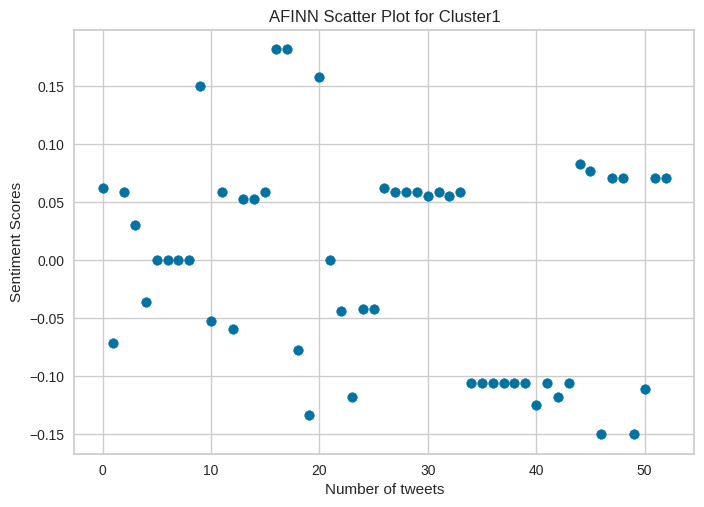

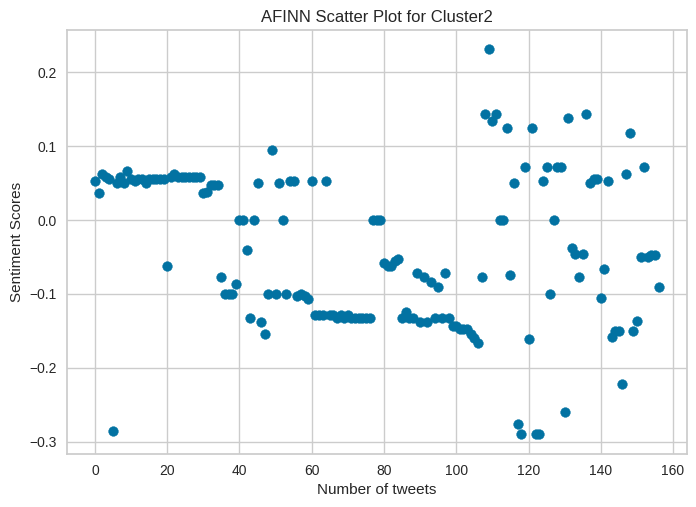

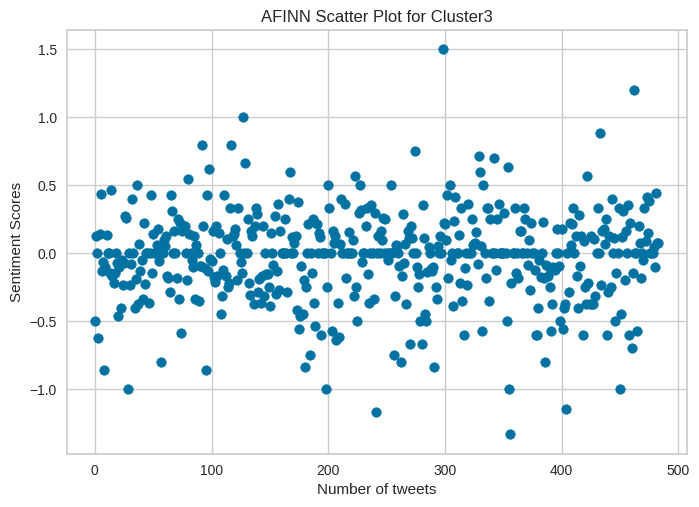

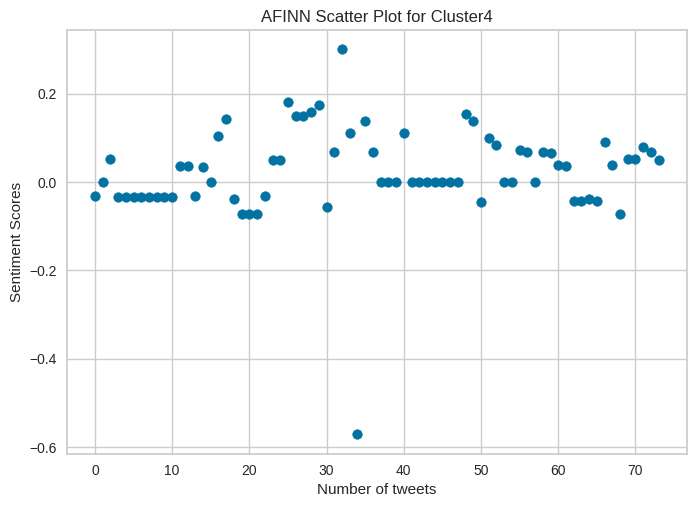

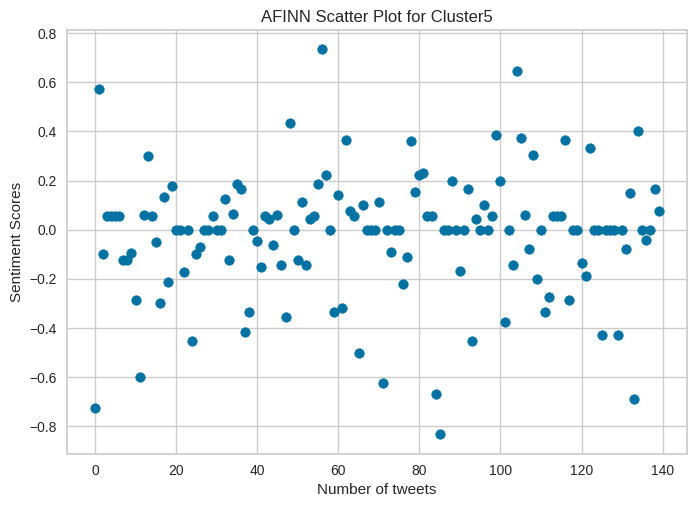

In [ ]:
economy_cluster_list_a = [economy_cluster1_list_a,economy_cluster2_list_a,economy_cluster3_list_a,economy_cluster4_list_a, economy_cluster5_list_a]
i = 1
for subscore in economy_cluster_list_a:
    x = range(len(subscore))
    plt.scatter(x, subscore)

# Set the x and y axis labels
    plt.xlabel('Number of tweets')
    plt.ylabel('Sentiment Scores')

# Set the title of the plot
    plt.title('AFINN Scatter Plot for Cluster' + str(i))
    i+=1

# Show the plot
    plt.show()

# ASSESSING SENTIMENT POLARITY AND SUBJECTIVITY POLARITY FOR EACH CLUSTER IN 


In [ ]:
UniqueNames = data['cluster'].unique()
UniqueNames

DataFrameDict = {elem : 
pd.DataFrame for elem in UniqueNames}
DataFrameDict

{4: pandas.core.frame.DataFrame,
 2: pandas.core.frame.DataFrame,
 0: pandas.core.frame.DataFrame,
 1: pandas.core.frame.DataFrame,
 3: pandas.core.frame.DataFrame}

In [ ]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = data[:][data.cluster == key]

In [ ]:
polaritycluster={elem : pd.DataFrame for elem in UniqueNames}
subjectivitycluster={elem : pd.DataFrame for elem in UniqueNames}
for i in DataFrameDict.keys():
    polaritycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweet'].astype('str'))).sentiment.polarity
    subjectivitycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweet'].astype('str'))).sentiment.subjectivity

### Polarity for all the clusters

In [ ]:
polaritycluster

{4: 0.07236428728276556,
 2: 0.061839586339586375,
 0: 0.07692307692307693,
 1: 0.08875,
 3: 0.09439759036144578}

### Subjectivity for all the clusters

In [ ]:
subjectivitycluster

{4: 0.4814896637179247,
 2: 0.4710962364110519,
 0: 0.04468864468864469,
 1: 0.23659722222222215,
 3: 0.1824096385542168}

## Visualizing the Polarity graph for all the clusters

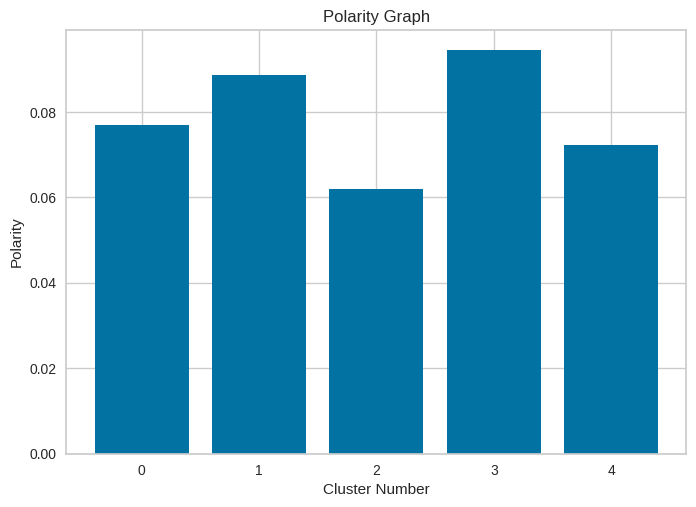

In [ ]:
plt.bar(list(polaritycluster.keys()), list(polaritycluster.values()))

plt.title('Polarity Graph')
plt.xlabel('Cluster Number')
plt.ylabel('Polarity')
plt.show()

## Visualizing the Subjectivity graph for all the clusters

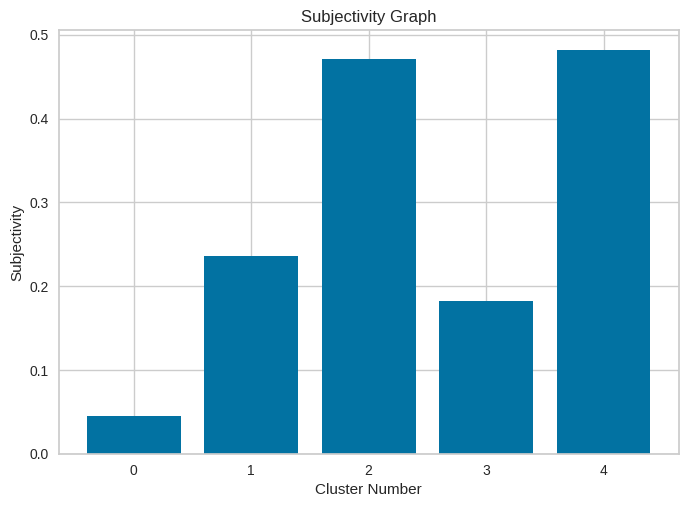

In [ ]:
plt.bar(list(subjectivitycluster.keys()), list(subjectivitycluster.values()))

plt.title('Subjectivity Graph')
plt.xlabel('Cluster Number')
plt.ylabel('Subjectivity')
plt.show()

## Visualizing the Polarity-Subjectivity Graph for all the clusters

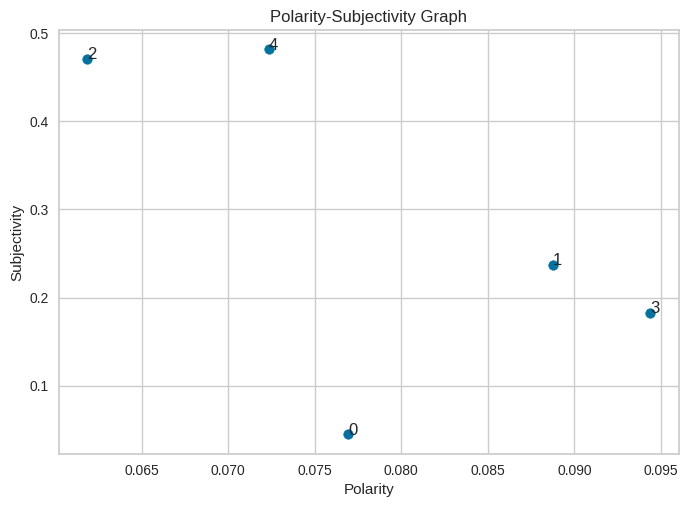

In [ ]:
#plt.scatter(list(polaritycluster.values()), list(subjectivitycluster.values()))

x=list(polaritycluster.values())
y=list(subjectivitycluster.values())

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, label in enumerate(polaritycluster.keys()):
    ax.annotate(label, (x[i], y[i]))

plt.title('Polarity-Subjectivity Graph')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

# PHASE 3 : KEYWORD ANALYSIS



# Word Cloud Analysis

In [ ]:
store_economy_clusters

[['africa',
  'agenda',
  'ahead',
  'american',
  'analysis',
  'anatomy',
  'anxiety',
  'areas',
  'article',
  'ass',
  'assignments',
  'assignmnets',
  'assure',
  'australian',
  'author',
  'bad',
  'basic',
  'bb',
  'benefit',
  'best',
  'biden',
  'bigtimerush',
  'leave',
  'letter',
  'level',
  'liberals',
  'libertarians',
  'lie',
  'life',
  'linguistics',
  'list',
  'listen',
  'literally',
  'literature',
  'live',
  'lmao',
  'loan',
  'local',
  'lock',
  'lockdown',
  'lockdowns',
  'lol',
  'long',
  'longer',
  'lose',
  'loss',
  'losses',
  'love',
  'low',
  'lower',
  'lowest',
  'macro',
  'madeinchelsea',
  'main',
  'major',
  'majority',
  'management',
  'mandate',
  'margins',
  'mark',
  'market',
  'marxist',
  'mask',
  'mass',
  'massive',
  'match',
  'math',
  'mathematics',
  'mathlab',
  'maths',
  'matter',
  'meat',
  'mechanics',
  'media',
  'men',
  'mention',
  'mess',
  'middle',
  'mil',
  'miles',
  'military',
  'millions',
  'mind'

In [ ]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:
        str1=str1+" "
        str1 += ele   
    
    # return string   
    return str1


## Word cloud visualization for all the clusters using the word cloud library

For Cluster: 
 1


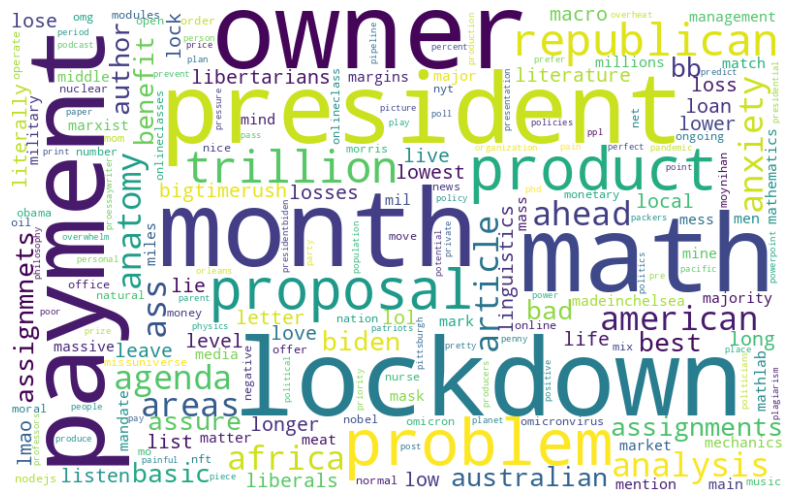



For Cluster: 
 2


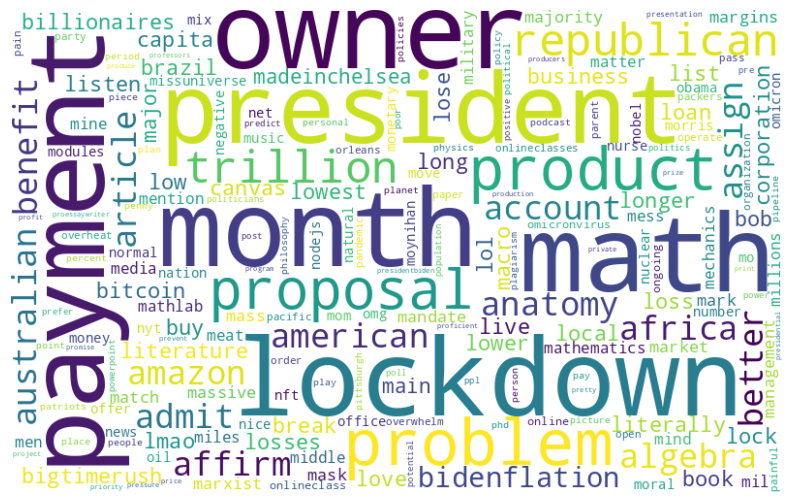



For Cluster: 
 3


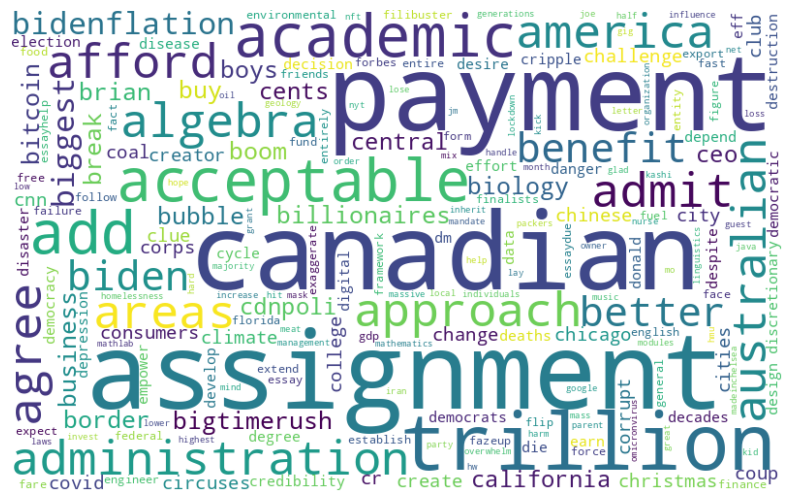



For Cluster: 
 4


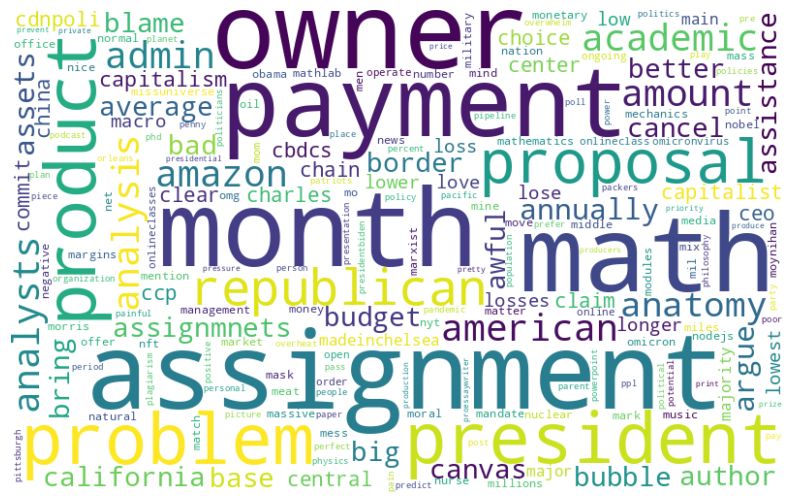



For Cluster: 
 5


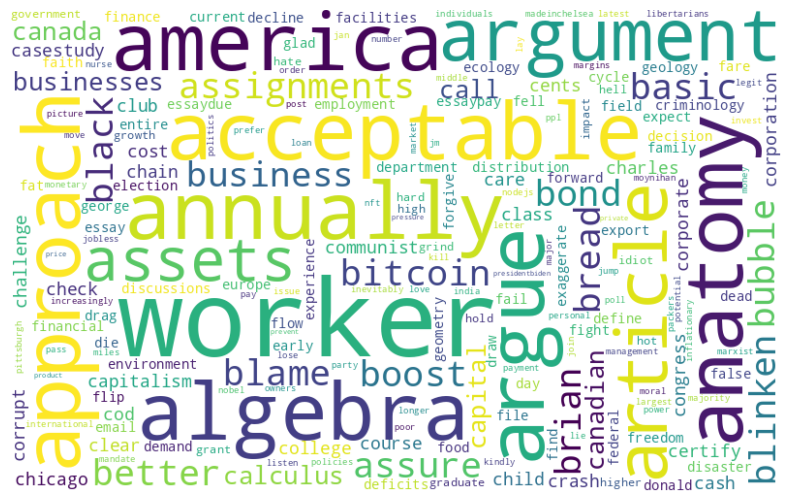

In [ ]:
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


for i in range(len(store_economy_clusters)):
  print("For Cluster: \n",i+1)
  word_string=listToString(np.unique(np.hstack(store_economy_clusters[i])).tolist())
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="white").generate(word_string)
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()
  print("\n")


# LDA TOPIC MODELLING

## For Cluster 1

In [ ]:
# Create Dictionary
mask = (data_economy['cluster']==0)
id2word = corpora.Dictionary(data_economy.loc[mask, 'tokenized_sents'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_economy['tokenized_sents']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Computing the coherence score for the clusters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

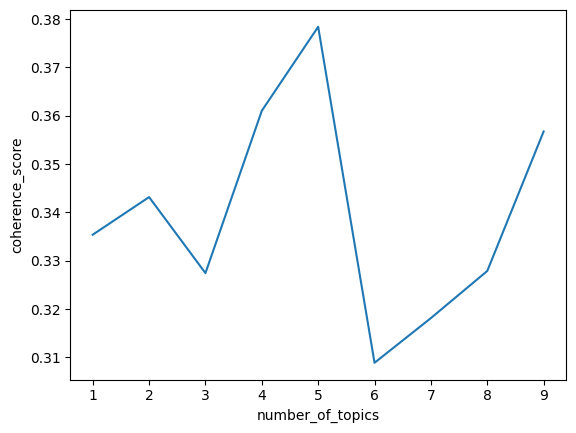

In [ ]:
# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=data_economy.loc[mask, 'tokenized_sents'], 
                                       dictionary=id2word, 
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

## Using the highest peak of the number of topics we are defining the n_topics below. 

##NOTE:  Inorder to get a broader idea and insights about users, sometimes we have selected the second highest peak as the number of topics.

In [ ]:
# Define the number of topics 
n_topics = 5

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.111*"essay" + 0.091*"pay" + 0.069*"biology" + 0.064*"economics" + 0.052*"help" + 0.052*"physics" + 0.043*"homework" + 0.042*"javascript" + 0.042*"assignments" + 0.041*"history"
Topic: 1 Word: 0.501*"economics" + 0.138*"grade" + 0.050*"data" + 0.045*"post" + 0.033*"work" + 0.030*"best" + 0.021*"choice" + 0.014*"course" + 0.012*"change" + 0.011*"help"
Topic: 2 Word: 0.306*"essaypay" + 0.155*"essaydue" + 0.055*"prices" + 0.045*"statistics" + 0.033*"mathematics" + 0.033*"handle" + 0.027*"expert" + 0.026*"onlineclasses" + 0.026*"essayhelp" + 0.024*"hesitate"
Topic: 3 Word: 0.342*"pay" + 0.104*"business" + 0.059*"exams" + 0.057*"final" + 0.037*"book" + 0.034*"review" + 0.033*"coding" + 0.030*"kindly" + 0.023*"high" + 0.022*"report"
Topic: 4 Word: 0.077*"math" + 0.065*"class" + 0.064*"write" + 0.057*"essays" + 0.056*"finance" + 0.053*"online" + 0.048*"psychology" + 0.044*"algebra" + 0.042*"assignment" + 0.041*"dm"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualizing the LDA modelling for all the topics defined above

In [ ]:
# Import and enable notebook to run visualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.273251  0.071433       1        1  51.529706
4      0.240025  0.242083       2        1  27.279877
3     -0.087364  0.147905       3        1   8.933796
1     -0.142873 -0.236017       4        1   6.549328
2      0.263463 -0.225403       5        1   5.707292, topic_info=               Term        Freq       Total Category  logprob  loglift
11        economics  469.000000  469.000000  Default  30.0000  30.0000
24              pay  553.000000  553.000000  Default  29.0000  29.0000
161        essaypay  125.000000  125.000000  Default  28.0000  28.0000
51            essay  409.000000  409.000000  Default  27.0000  27.0000
21             math  150.000000  150.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
194      succession    1.631880    3.262418   Topic5  -5.5223   2.1707
168         ecology    2.983154    6.355447   Topic5  -4.9190   2.1071
59       statistics   18.260438   64.953644   Topic5  -3.1073   1.5945
195        umarriaz    1.631880    3.262418   Topic5  -5.5223   2.1707
196  weloveyoujimin    1.631880    3.262418   Topic5  -5.5223   2.1707

[207 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
187       4  0.306521  abudhabigp
187       5  0.613042  abudhabigp
0         5  0.929028    academic
73        1  0.996323  accounting
227       1  0.335548    accounts
...     ...       ...         ...
87        4  0.942082        work
125       2  0.994176       write
214       1  0.098452     writing
214       2  0.393809     writing
214       3  0.393809     writing

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

## Repeating the same process for all clusters 

## For Cluster 2

In [ ]:
# Create Dictionary
mask = (data_economy['cluster']==1)
id2word = corpora.Dictionary(data_economy.loc[mask, 'tokenized_sents'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_economy['tokenized_sents']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

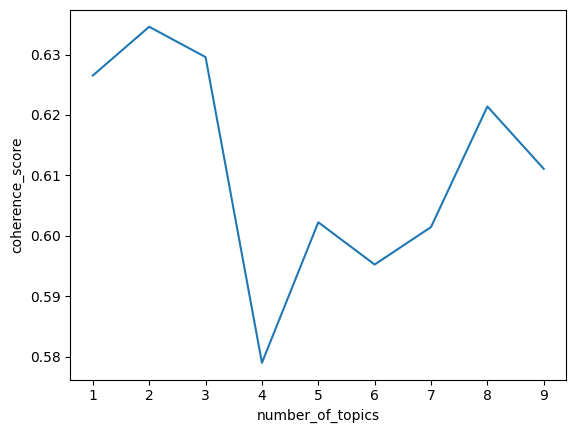

In [ ]:
# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=data_economy.loc[mask, 'tokenized_sents'], 
                                       dictionary=id2word, 
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [ ]:
# Define the number of topics 
n_topics = 3

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.034*"prices" + 0.023*"higher" + 0.020*"pandemic" + 0.019*"american" + 0.018*"food" + 0.018*"profits" + 0.018*"forced" + 0.017*"record" + 0.017*"corporations" + 0.015*"cost"
Topic: 1 Word: 0.163*"class" + 0.157*"finance" + 0.061*"business" + 0.039*"law" + 0.029*"good" + 0.027*"tomorrow" + 0.022*"political" + 0.014*"high" + 0.013*"politics" + 0.011*"great"
Topic: 2 Word: 0.229*"pay" + 0.224*"economics" + 0.132*"biology" + 0.103*"help" + 0.059*"math" + 0.027*"stats" + 0.010*"quality" + 0.010*"data" + 0.009*"post" + 0.009*"analysis"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Import and enable notebook to run visualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.169926  0.193258       1        1  40.949524
2      0.329675  0.004018       2        1  33.796672
1     -0.159750 -0.197276       3        1  25.253805, topic_info=            Term        Freq       Total Category  logprob  loglift
95           pay  460.000000  460.000000  Default  30.0000  30.0000
218    economics  450.000000  450.000000  Default  29.0000  29.0000
352      finance  237.000000  237.000000  Default  28.0000  28.0000
59         class  257.000000  257.000000  Default  27.0000  27.0000
948      biology  265.000000  265.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
589       amount    3.601226    5.888376   Topic3  -6.0300   0.8845
496  millennials    6.058965   14.342184   Topic3  -5.5097   0.5145
592      putting    4.082716    7.454741   Topic3  -5.9045   0.7741
653   overheated    5.398251   14.718477   Topic3  -5.6252   0.3732
588        admin    4.425508    9.959383   Topic3  -5.8239   0.5651

[136 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
588       1  0.502039     admin
588       3  0.401631     admin
519       1  0.980340  american
589       1  0.339652    amount
589       3  0.679304    amount
...     ...       ...       ...
146       1  0.106023     worth
146       2  0.106023     worth
146       3  0.742160     worth
37        1  0.214987     years
37        2  0.644961     years

[225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

## For Cluster 3

In [ ]:
# Create Dictionary
mask = (data_economy['cluster']==2)
id2word = corpora.Dictionary(data_economy.loc[mask, 'tokenized_sents'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_economy['tokenized_sents']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

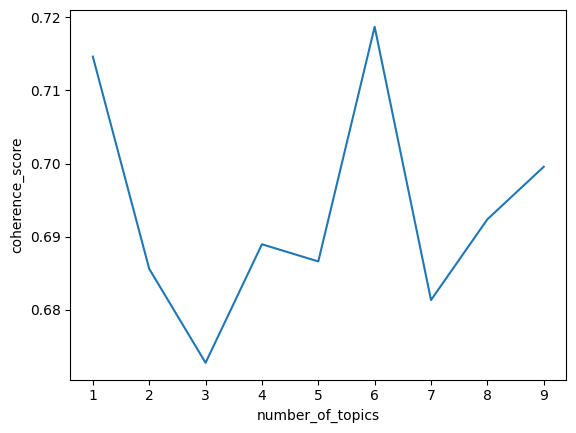

In [ ]:
# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=data_economy.loc[mask, 'tokenized_sents'], 
                                       dictionary=id2word, 
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [ ]:
# Define the number of topics 
n_topics = 6

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.546*"pay" + 0.039*"business" + 0.021*"final" + 0.018*"good" + 0.015*"best" + 0.014*"book" + 0.013*"review" + 0.010*"school" + 0.009*"high" + 0.008*"policy"
Topic: 1 Word: 0.280*"history" + 0.021*"american" + 0.021*"political" + 0.015*"power" + 0.013*"things" + 0.013*"choosing" + 0.013*"top" + 0.012*"hallmark" + 0.012*"flattening" + 0.012*"activities"
Topic: 2 Word: 0.539*"economics" + 0.067*"grade" + 0.016*"work" + 0.015*"education" + 0.014*"study" + 0.012*"author" + 0.011*"dies" + 0.011*"iconoclastic" + 0.011*"charles" + 0.011*"morris"
Topic: 3 Word: 0.127*"help" + 0.102*"homework" + 0.094*"paper" + 0.073*"math" + 0.064*"calculus" + 0.062*"thesis" + 0.053*"finance" + 0.045*"psychology" + 0.043*"accounting" + 0.041*"sociology"
Topic: 4 Word: 0.028*"higher" + 0.025*"point" + 0.024*"pandemic" + 0.019*"private" + 0.018*"cost" + 0.017*"start" + 0.016*"choice" + 0.015*"gas" + 0.013*"profit" + 0.013*"better"
Topic: 5 Word: 0.176*"class" + 0.038*"prices" + 0.027*"families" + 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Import and enable notebook to run visualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.417264  0.029505       1        1  27.957239
0      0.049508 -0.348372       2        1  17.761801
5      0.103202  0.070560       3        1  14.348587
4      0.099629  0.049153       4        1  14.333535
2      0.090989  0.155693       5        1  14.292987
1      0.073935  0.043461       6        1  11.305852, topic_info=               Term        Freq       Total Category  logprob  loglift
882             pay  684.000000  684.000000  Default   30.000  30.0000
3         economics  544.000000  544.000000  Default   29.000  29.0000
128         history  223.000000  223.000000  Default   28.000  28.0000
45            class  178.000000  178.000000  Default   27.000  27.0000
761            help  251.000000  251.000000  Default   26.000  26.0000
...             ...         ...         ...      ...      ...      ...
1036        belongs    4.665444    6.260226   Topic6   -5.142   1.8858
1037       category    4.665444    6.260226   Topic6   -5.142   1.8858
1041       mortgage    4.665444    6.260226   Topic6   -5.142   1.8858
1044  qualitatively    4.665444    6.260226   Topic6   -5.142   1.8858
1045         spouse    4.665444    6.260226   Topic6   -5.142   1.8858

[241 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
964       1  0.990732  accounting
1034      6  0.958312  activities
1046      3  0.820034       adult
1046      5  0.136672       adult
1046      6  0.136672       adult
...     ...       ...         ...
18        5  0.952892        work
990       2  0.892133       worth
733       6  0.787963       wrong
566       4  0.910395         wtf
461       2  0.962522       years

[255 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 5, 3, 2])

## For Cluster 4

In [ ]:
# Create Dictionary
mask = (data_economy['cluster']==3)
id2word = corpora.Dictionary(data_economy.loc[mask, 'tokenized_sents'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_economy['tokenized_sents']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

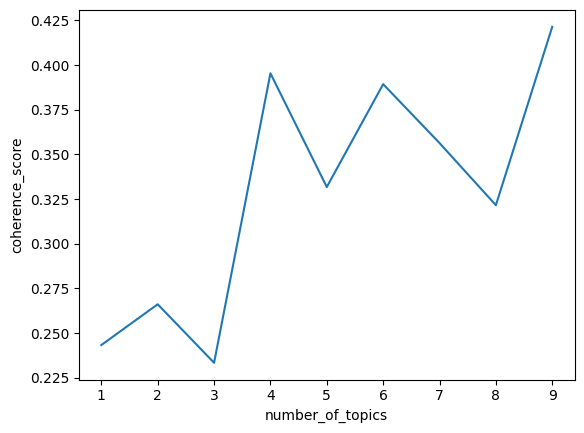

In [ ]:
# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=data_economy.loc[mask, 'tokenized_sents'], 
                                       dictionary=id2word, 
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [ ]:
# Define the number of topics 
n_topics = 4

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.166*"pay" + 0.155*"essay" + 0.079*"biology" + 0.074*"help" + 0.060*"homework" + 0.055*"paper" + 0.051*"economics" + 0.036*"thesis" + 0.036*"write" + 0.034*"chemistry"
Topic: 1 Word: 0.497*"economics" + 0.083*"discussion" + 0.052*"term" + 0.052*"data" + 0.046*"analysis" + 0.034*"handle" + 0.022*"canvas" + 0.016*"hesitate" + 0.015*"article" + 0.012*"searching"
Topic: 2 Word: 0.130*"class" + 0.111*"finance" + 0.106*"online" + 0.093*"psychology" + 0.053*"fall" + 0.043*"business" + 0.041*"english" + 0.040*"classes" + 0.034*"papers" + 0.029*"law"
Topic: 3 Word: 0.064*"javascript" + 0.063*"assignments" + 0.062*"history" + 0.051*"nursing" + 0.048*"physics" + 0.047*"essaypay" + 0.046*"math" + 0.045*"english" + 0.045*"economics" + 0.041*"dm"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Import and enable notebook to run visualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.252304 -0.261358       1        1  44.740962
3     -0.006957  0.138555       2        1  27.375289
2     -0.364307 -0.108216       3        1  21.042464
1      0.118959  0.231018       4        1   6.841285, topic_info=            Term        Freq       Total Category  logprob  loglift
3      economics  472.000000  472.000000  Default  30.0000  30.0000
12           pay  509.000000  509.000000  Default  29.0000  29.0000
4          essay  475.000000  475.000000  Default  28.0000  28.0000
35         class  188.000000  188.000000  Default  27.0000  27.0000
40       finance  160.000000  160.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
155     articles    0.892573    2.620336   Topic4  -6.2632   1.6052
158     journals    0.892573    2.620336   Topic4  -6.2632   1.6052
154  infographic    0.845468    2.227778   Topic4  -6.3174   1.7133
133   plagiarism    0.935472    3.989528   Topic4  -6.2162   1.2318
135       timely    0.935472    3.989528   Topic4  -6.2162   1.2318

[181 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
139       4  0.919782     account
17        1  0.987022  accounting
137       1  0.361384    accounts
137       3  0.361384    accounts
137       4  0.361384    accounts
...     ...       ...         ...
136       3  0.130327     writing
136       4  0.260654     writing
182       1  0.201805        wssu
182       3  0.403611        wssu
182       4  0.403611        wssu

[207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

## For Cluster 5

In [ ]:
# Create Dictionary
mask = (data_economy['cluster']==4)
id2word = corpora.Dictionary(data_economy.loc[mask, 'tokenized_sents'])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_economy['tokenized_sents']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

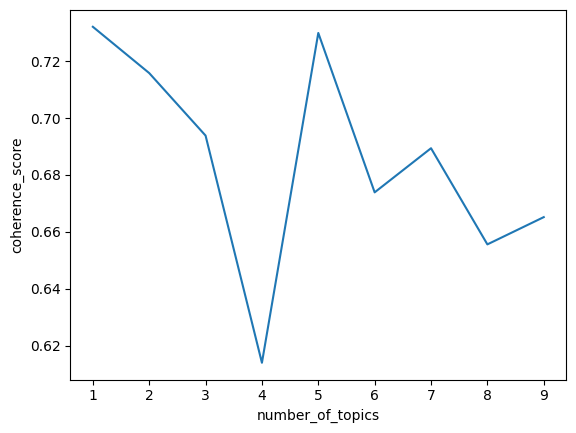

In [ ]:
# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1,10):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  coherence_model_lda = CoherenceModel(model=lda_model, 
                                       texts=data_economy.loc[mask, 'tokenized_sents'], 
                                       dictionary=id2word, 
                                       coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  number_of_topics.append(i)
  coherence_score.append(coherence_lda)

# Create a dataframe of coherence score by number of topics 
topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score':coherence_score})

# Print a line plot
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score')

In [ ]:
# Define the number of topics 
n_topics = 5

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.140*"history" + 0.115*"nursing" + 0.103*"math" + 0.088*"class" + 0.075*"finance" + 0.071*"online" + 0.018*"project" + 0.018*"quality" + 0.016*"post" + 0.016*"analysis"
Topic: 1 Word: 0.340*"economics" + 0.156*"help" + 0.151*"physics" + 0.024*"discussion" + 0.015*"data" + 0.010*"offer" + 0.009*"experts" + 0.005*"politics" + 0.004*"course" + 0.004*"read"
Topic: 2 Word: 0.028*"point" + 0.026*"political" + 0.020*"cost" + 0.018*"power" + 0.016*"revenue" + 0.015*"neoliberal" + 0.015*"hallmark" + 0.015*"flattening" + 0.015*"activities" + 0.015*"plane"
Topic: 3 Word: 0.453*"pay" + 0.033*"business" + 0.024*"science" + 0.022*"philosophy" + 0.020*"term" + 0.015*"good" + 0.012*"pandemic" + 0.012*"american" + 0.011*"book" + 0.011*"study"
Topic: 4 Word: 0.030*"prices" + 0.021*"families" + 0.021*"higher" + 0.018*"work" + 0.018*"education" + 0.016*"food" + 0.016*"profits" + 0.016*"forced" + 0.015*"record" + 0.014*"corporations"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Import and enable notebook to run visualization
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.023480 -0.035490       1        1  24.494283
4      0.024061 -0.058717       2        1  22.974789
3      0.076573 -0.237802       3        1  20.124361
1     -0.313590  0.084387       4        1  17.424524
0      0.189475  0.247622       5        1  14.982043, topic_info=           Term        Freq       Total Category  logprob  loglift
169         pay  801.000000  801.000000  Default  30.0000  30.0000
2271  economics  521.000000  521.000000  Default  29.0000  29.0000
281        help  239.000000  239.000000  Default  28.0000  28.0000
1120    physics  232.000000  232.000000  Default  27.0000  27.0000
686     history  185.000000  185.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
103        sure    2.789509    3.946887   Topic5  -6.1568   1.5513
2192      stuck    1.830992    3.047877   Topic5  -6.5779   1.3887
1208      crash    1.573549    2.757130   Topic5  -6.7294   1.3375
127     writers    2.461324    5.598931   Topic5  -6.2820   1.0764
1299   services    2.848907   10.950886   Topic5  -6.1358   0.5518

[192 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1547      4  0.702479    academic
2321      1  0.977966  activities
451       2  0.043988    american
451       3  0.923754    american
1809      5  0.970807    analysis
...     ...       ...         ...
465       3  0.791726       wrong
1457      2  0.205637         wtf
1457      4  0.822548         wtf
653       3  0.889790        year
270       1  0.946391       years

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

# SUMMARIZATION ANALYSIS

## Cleaning the data for the summarization.

In [ ]:
#written by Gina Roh
pd.set_option('display.max_colwidth',1200)

#data_sum_copy = data_sum_tech.copy()
data_sum_copy = data.copy()

#concatenate all the tweets within each cluster to form a single document for each cluster
data_sum_copy['tweet'] = data_sum_copy.groupby(['cluster'])['tweet'].transform(lambda x : '. '.join(x))
data_sum_final = data_sum_copy.drop_duplicates(subset=['tweet'])
data_sum_final

user         location  \
0             KDWS__      Atlanta, GA   
1          HairWeave     Philadelphia   
449   CustomPapers13    United States   
454  SMARTBESTONLIN1  California, USA   
470    Custompapers5              USA   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               tweet  \
0    hard disagree worry tweet joe biden lack competency example inflation stock. laughable inflation mandate freedom toilet joke fuks. people gratitude people keep years deal general garbage people shop. number americans file initial jobless claim unexpectedly fell lowest level years fare better economists expect forbes detail employment. number americans file initial jobless claim unexpectedly fell lowest level years fare better economists expect forbes detail employment. number americans file initial jobless claim unexpectedly fell lowest level years fare better economists expect forbes detail employment. president congress protect global inflation presidents credit blame authority set wag price interest rat despite dow unprecedented highs. people realize financial system house burn card build sand high tide class hurricane bear amp crash. empathy eliminate virus declare war tire shade george mission accomplish effort people good people sick dead. lockdowns damage good cost benefit analysis cost protect healthcare system overwhelm higher term collapse global amp domestic generations pay inflation debt. proof state education failure people vaccine work gun laws criminals print mon...   
1    fair finance whore critical totally condone finance corporate government amp mob whore. wsj biden stagflation usa america biden trump trump freedom patriots democrats republicans inflation gasprices bidenflation politics. canada underfunding defense defend canada defend canada country neuter europe establish global roles reverse. osha open investigation amazon warehouse collapse tornado kill. blinken develop comprehensive indo pacific economic framework pursue share objectives include trade digital biden administration flesh framework entail clue today speech. interest place curator grow popularity street tour find cool land mark stories combine person kind conflux. ecommerce middleware servuce distract users convenience feel submit purchase power surveillance open source commodity eanal. glad respectable scientists tweet start feel lonely omicron serious threat america health response leave desire. sure hurt owners sad fact long game result hurt idiots change disastrous tyrannical move. hey elizabeth net worth north awful yell create real produce. well ship guy build typeshare talk creator build platform flock real famous writers ceo medium. pl planet labs pbc result earn call...   
449  help assignments pay phy maths stats finals essay chemistry history nurse javascript calculus geography thesis trigonometry. grade nurse phy

## Using SUMY and Lexrank summarizer for summarizing the top tweets

In [ ]:
#written by Gina Roh
import textwrap
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

print("LexRank")
for i in range(5):
  print ("----------")
  print ("Cluster %d:" % i)
  document1 = data_sum_final.loc[data_sum_final['cluster'].eq(i), 'tweet'].astype(str)
  document1 = str(document1)[4:].strip()
  parser = PlaintextParser.from_string(document1,Tokenizer("english"))
  
  #using LexRank
  summarizer = LexRankSummarizer()
  #summarize the document with seven sentence
  summary = summarizer(parser.document, 7)
  
  #The first five unduplicated sentences are printed
  num = 0
  sum_result = []
  for sentence in summary:
    if str(sentence) not in sum_result:
      sum_result.append(str(sentence))
      num += 1
    if num == 5:
      break
  
  # Wrap this text
  wrapper = textwrap.TextWrapper(width=100)  
  word_list = wrapper.wrap(text=" ".join(sum_result))
    
  # Print each line
  for element in word_list:
      print(element)

LexRank
----------
Cluster 0:
help assignments pay phy maths stats finals essay chemistry history nurse javascript calculus
geography thesis trigonometry. grade nurse physics chemistry literature english essay pay account
essay history assignments microbiology biology. help assignments pay physics biology english essay
finals essay chemistry history nurse javascript calculus geography thesis trigonometry. hand
assignments physics biology english essay pay maths stats essay chemistry history physical science
calculus essay help geography thesis txsu su su txsu nccu ssu lsu asutwitte su txsu txsu tamu aamu
jsu. well handle assignments dm biology psychology sociology paper literature essay pay maths hw
statistics exams essay history nurse physics javascript calculus algebra excel essaypay thesis
discussion umhb dm.
----------
Cluster 1:
trigonometry chemistry physics help thesis maths biology powerpoint sociology account essay essay
pay casestudy literature term paper whatsapp text. onlin

## Using Luhn summarizer for summarizing the top tweets

In [ ]:
#written by Gina Roh
from sumy.summarizers.luhn import LuhnSummarizer

print("Luhn")
for i in range(5):
  print ("----------")
  print ("Cluster %d:" % i)
  document1 = data_sum_final.loc[data_sum_final['cluster'].eq(i), 'tweet'].astype(str)
  document1 = str(document1)[4:].strip()
  parser = PlaintextParser.from_string(document1,Tokenizer("english"))
  
  #using Luhn
  summarizer_luhn = LuhnSummarizer()
  #summarize the document with seven sentence
  summary_l =summarizer_luhn(parser.document,7)
  
  #The first five unduplicated sentences are printed
  num = 0
  sum_result = []
  for sentence in summary_l:
    if str(sentence) not in sum_result:
      sum_result.append(str(sentence))
      num += 1
    if num == 5:
      break
  
  # Wrap this text
  wrapper = textwrap.TextWrapper(width=100)  
  word_list = wrapper.wrap(text=" ".join(sum_result))
    
  # Print each line
  for element in word_list:
      print(element)

Luhn
----------
Cluster 0:
help assignments pay phy maths stats finals essay chemistry history nurse javascript calculus
geography thesis trigonometry. grade nurse physics chemistry literature english essay pay account
essay history assignments microbiology biology. help assignments pay physics biology english essay
finals essay chemistry history nurse javascript calculus geography thesis trigonometry. hand
assignments physics biology english essay pay maths stats essay chemistry history physical science
calculus essay help geography thesis txsu su su txsu nccu ssu lsu asutwitte su txsu txsu tamu aamu
jsu. well handle assignments dm biology psychology sociology paper literature essay pay maths hw
statistics exams essay history nurse physics javascript calculus algebra excel essaypay thesis
discussion umhb dm.
----------
Cluster 1:
trigonometry chemistry physics help thesis maths biology powerpoint sociology account essay essay
pay casestudy literature term paper whatsapp text. trigonom

## Both the summarizers gave similar results and we have used both to compare with the normal summarizer and get insights for the same.

In [ ]:
#make panda's max_cowidth setting back
pd.set_option('display.max_colwidth',100)